In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
from skimage.morphology import binary_erosion, convex_hull_image, convex_hull_object
from matplotlib.colors import ListedColormap
import matplotlib.patches as pltpat

import math
import time
import random
from matplotlib import cm
from collections import deque

from geopy.distance import lonlat, distance

from Astar_netcdf import AStarPlanner
from rrtstar_netcdf import RRTStar
from rrt_netcdf import RRT
show_animation = False

In [714]:
data = xr.open_dataset('wave2021.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = data.variables['time'][:]
# 2021-07-18, 2021-08-23, 2021-08-24, 2021-09-10, 2021-09-18, 
# 2021-10-11, 2021-10-22, 2021-10-27, 2021-10-31, 2021-11-05, 2021-12-18, 2021-03-07
july18 = data.sel(time='2021-10-11') 
wave = july18.variables['VHM0'][:]

july18

<xarray.Dataset>
Dimensions:    (latitude: 47, time: 24, longitude: 62)
Coordinates:
  * latitude   (latitude) float32 41.35 41.4 41.44 41.48 ... 43.19 43.23 43.27
  * time       (time) datetime64[ns] 2021-10-11 ... 2021-10-11T23:00:00
  * longitude  (longitude) float32 8.958 9.0 9.042 9.083 ... 11.42 11.46 11.5
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    bulletin_type:                   forecast
    institution:                     Hellenic Centre for Marine Research (HCM...
    source:                          MEDWAM3
    credit:                          Copernicus Marine Environment Monitoring...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    producer:                        CMEMS-MED Monitoring and Forecasting Centre
    ...                              ...
    area:                            MED
    bulletin_date:                   2022-01-04 12
    FROM_ORIGINAL_FILE__field_type:  hourly_instantaneous_at_time_field
    title:                           Wave fields (2D) - Hourly Instantaneous
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    history:                         Data extracted from dataset http://local...

In [3]:
# general basemap of Italy configuration space
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58, 
             urcrnrlon=15.13, 
             urcrnrlat=45.5488,  
             resolution='i')

# lon, lat = np.meshgrid(lons, lats)   # 62 x 47
# x, y = mp(lon, lat)
# lon_mask, lat_mask = np.meshgrid(lons_mask, lats_mask)  # 1307 x 380
# x_mask, y_mask = mp(lon_mask, lat_mask)

# x_min, y_min = mp(lons.values[0], lats.values[0]) 
# x_max, y_max = mp(lons.values[-1], lats.values[-1]) 

# basemap for zoom plots
mp2 = Basemap(projection='merc',
             llcrnrlon=lons.values[0],  
             llcrnrlat=lats.values[0], 
             urcrnrlon=lons.values[-1], 
             urcrnrlat=lats.values[-1],  
             resolution='f')
lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp2(lon, lat)
lon_mask, lat_mask = np.meshgrid(lons_mask, lats_mask)  # 1307 x 380
x_mask, y_mask = mp2(lon_mask, lat_mask)

In [694]:
s1x, s1y = mp2(lons.values[12], lats.values[7])
g1x, g1y = mp2(lons.values[50], lats.values[28])
g2x, g2y = mp2(lons.values[39], lats.values[33])

In [715]:
l = 24
li = 5  # 4   4(7-5)  4   3   2  -  5   11    0    0    3    6    3   
le = 17  # 18  18    18  17    15  - 17   23   12   12   15   18   15   
cost = np.zeros_like(wave[li:le])
contour_raw_meteo = np.zeros_like(wave[li:le])
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(le-li):
    cost[i] = 100 * (np.array(wave[i+li]) > 0.8)
    contour_raw_meteo[i]=np.logical_xor(cost[i],binary_erosion(cost[i]))


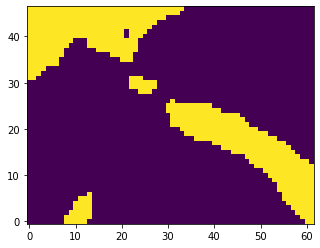

In [699]:
plt.imshow(cost15, origin='lower')

In [664]:
# sum
cost15 = 0
for i in range(len(cost)):
    cost15 += cost[i]
cost15 = 100*(np.array(cost15)>=100)

contour15 = np.logical_xor(cost15,binary_erosion(cost15))
# -----------------------------------------------------------------

x_obsl, y_obsl = [], []
oxmeteo, oymeteo = [], []     # all meteo points
x_obsm, y_obsm = [], []       # contour meteo points
oxmeteo_, oymeteo_ = [], []   # all meteo points
x_obsm_, y_obsm_ = [], []     # contour meteo points


for k in np.arange(0,47,1):
    for j in np.arange(0,62,1):
        if cost15[k][j]:
            oxmeteo.append(lons.values[j])
            oymeteo.append(lats.values[k])
        if contour15[k][j]:
            x_obsm.append(lons.values[j])
            y_obsm.append(lats.values[k])
x_obsm_, y_obsm_ = mp2(x_obsm, y_obsm)       # meteo contour points
oxmeteo_, oymeteo_ = mp2(oxmeteo, oymeteo)       # meteo contour points
# land is always static    

for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]:
#                     if lons_mask.values[j] > 9.8:
                        x_obsl.append(lons_mask.values[j])
                        y_obsl.append(lats_mask.values[k])
                    
x_obsl_, y_obsl_ = mp2(x_obsl, y_obsl)       # coastline points

In [716]:
# local
xspace = lons.values
yspace = lats.values

sx = xspace[12]  
sy = yspace[7] 
gx = xspace[50]   # [29]  39
gy = yspace[28]   # [37]  33
# sx_init, sy_init = mp(sx, sy)
# gx_a, gy_a = mp(gx, gy)

x_obsl, y_obsl = [], []  # contour land points
oxmeteo, oymeteo = [[] for i in range(le-li)], [[] for i in range(le-li)]     # all meteo points
oxmeteo_, oymeteo_ = [[] for i in range(le-li)], [[] for i in range(le-li)]   # all meteo points
x_obsm, y_obsm = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
x_obsm_, y_obsm_ = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
map_x, map_y = [], []  
map_x_, map_y_ = [], [] 
map_x2, map_y2 = [], []  
map_x_2, map_y_2 = [], [] 
image = np.zeros((47, 62))

for i in range(le-li):
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if cost[i][k][j] == 100:
                oxmeteo[i].append(lons.values[j])
                oymeteo[i].append(lats.values[k])
                geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(xspace[12],yspace[7]))).km
                if 18*(i) < geo_dist < 18*(i+1):
                    map_x.append(lons.values[j])
                    map_y.append(lats.values[k]) 
                    image[k][j] = 1
    oxmeteo_[i], oymeteo_[i] = mp2(oxmeteo[i], oymeteo[i]) 

for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]: 
                    x_obsl.append(lons_mask.values[j])
                    y_obsl.append(lats_mask.values[k])

map_x_, map_y_ = mp2(map_x, map_y)       # map contour points                
x_obsl_, y_obsl_ = mp2(x_obsl, y_obsl)       # coastline points

astar_contour = np.logical_xor(image,binary_erosion(image)) 
for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if astar_contour[k][j]:
                map_x2.append(lons.values[j])
                map_y2.append(lats.values[k]) 
map_x_2, map_y_2 = mp2(map_x2, map_y2)       # map contour points 

In [672]:
# global
x_obsl, y_obsl = [], []

x_obsm, y_obsm = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
x_obsm_, y_obsm_ = [[] for i in range(le-li)], [[] for i in range(le-li)]     # contour meteo points

oxmeteo, oymeteo = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
oxmeteo_, oymeteo_ = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
for i in range(le-li):
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if cost[i][k][j]:
                oxmeteo[i].append(lons.values[j])
                oymeteo[i].append(lats.values[k])        
            if contour_raw_meteo[i][k][j]:
                x_obsm[i].append(lons.values[j])
                y_obsm[i].append(lats.values[k])
    x_obsm_[i], y_obsm_[i] = mp2(x_obsm[i], y_obsm[i])           # meteo contour points
    oxmeteo_[i], oymeteo_[i] = mp2(oxmeteo[i], oymeteo[i])       # meteo points
    
# land is always static    
for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]: 
                    if lons_mask.values[j] > 9.6:
                        x_obsl.append(lons_mask.values[j])
                        y_obsl.append(lats_mask.values[k])
    
x_obsl_, y_obsl_ = mp2(x_obsl, y_obsl)       # coastline points

In [718]:
## reverse paths
# local
xspace = lons.values
yspace = lats.values

sx = xspace[50]  
sy = yspace[28] 
gx = xspace[12]   # [29]  39
gy = yspace[7]   # [37]  33
# sx_init, sy_init = mp(sx, sy)
# gx_a, gy_a = mp(gx, gy)

x_obsl, y_obsl = [], []  # contour land points
oxmeteo, oymeteo = [[] for i in range(le-li)], [[] for i in range(le-li)]     # all meteo points
oxmeteo_, oymeteo_ = [[] for i in range(le-li)], [[] for i in range(le-li)]   # all meteo points
x_obsm, y_obsm = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
x_obsm_, y_obsm_ = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
map_x, map_y = [], []  
map_x_, map_y_ = [], [] 
map_x2, map_y2 = [], []  
map_x_2, map_y_2 = [], [] 
image = np.zeros((47, 62))

for i in range(le-li):
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if cost[i][k][j] == 100:
                oxmeteo[i].append(lons.values[j])
                oymeteo[i].append(lats.values[k])
                geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(sx,sy))).km
                if 18*(i) < geo_dist < 18*(i+1):
                    map_x.append(lons.values[j])
                    map_y.append(lats.values[k]) 
                    image[k][j] = 1
    oxmeteo_[i], oymeteo_[i] = mp2(oxmeteo[i], oymeteo[i]) 

for k in np.arange(0,380,1):
        for j in np.arange(0,1307,1):
            if lons_mask.values[650] <= lons_mask.values[j] <= lons_mask.values[711] and lats_mask.values[268] <= lats_mask.values[k] <= lats_mask.values[314]:                      
                if contour_raw_land[k][j]: 
                    x_obsl.append(lons_mask.values[j])
                    y_obsl.append(lats_mask.values[k])

map_x_, map_y_ = mp2(map_x, map_y)       # map contour points                
x_obsl_, y_obsl_ = mp2(x_obsl, y_obsl)       # coastline points

astar_contour = np.logical_xor(image,binary_erosion(image)) 
for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if astar_contour[k][j]:
                map_x2.append(lons.values[j])
                map_y2.append(lats.values[k]) 
map_x_2, map_y_2 = mp2(map_x2, map_y2)       # map contour points 

In [708]:
import pickle
# ast_list_s1, ast_list_s2, glo_ast1, glo_ast2, locpatha1, locpatha2, sum_astarx1, sum_astarx2, sum_astary1, sum_astary2
# apf_list_s1, apf_list_s2, gloapf1, gloapf2, locapf1, locapf2, sumapf1, sumapf2 
# rrt_list_s1, rrt_list_s2, glopathrrt1, glopathrrt2, locbandrrt1, locbandrrt2, sum_rrt1, sum_rrt2

# a1_list, a2_list, aglo1, aglo2, aloc1, aloc2, asumx1, asumx1, asumy1, asumy2
# apflist1, apflist2, gloapf1, gloapf2, locapf1, locapf2, sumapf1, sumapf2
# r1list, r2list, rrtglo1, rrtglo2, rrtloc1, rrtloc2, rrtglo1, rrtglo2, rrtsum1, rrtsum2 

# glopatha50, glopatha39, gloapf50, gloapf39, glopathrrt50, glopathrrt39
# ast_list_s50, ast_list_s39, apf_list_s50, apf_list_s39, rrt_list_s50, rrt_list_s39
# improvedrrt50, improvedrrt39
# locpatha50, locpatha39, locapf50, locapf50, locbandrrt50, locbandrrt39
file_name = "pathstar6loc.pkl" 
open_file = open(file_name, "rb")
pathstar6loc = pickle.load(open_file)
open_file.close()

# file_name = "gloapf1.pkl"
# open_file = open(file_name, "wb")
# pickle.dump(gloapf1, open_file)
# open_file.close()

In [38]:
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# mp.plot(s1x, s1y, ">k", markersize=40)
# mp.plot(g1x, g1y, "Xr", markersize=20)
# mp.plot(g2x, g2y, "Xb", markersize=20)

# mp.plot(xal1[0], yal1[0], '-', label='Local A*')

# mp.fillcontinents()
# ax.legend(prop={"size":20})
# mp.drawcoastlines()
# mp.drawstates()
# mp.drawcountries()
# plt.show()

In [276]:
# gloapf1[6][1].append(apflist1[6][1][-1])
# print(gloapf1[6][1])
r=12

In [167]:
# path_dist = 0
# for i in range(len(gloapf1[6][1])-1):
#     path_dist += distance(lonlat(*(gloapf1[6][0][i],gloapf1[6][1][i])), lonlat(*(gloapf1[6][0][i+1],gloapf1[6][1][i+1]))).km
# print("Travel time = ", str(round(path_dist/18,4)), "hours")

In [687]:
# Initialization
# RRT 
# local
r = 12
# rrtloc1_geo = [np.zeros_like(rrtloc1[i]) for i in range(r)]
# rrtloc1_mp2 = [np.zeros_like(rrtloc1[i]) for i in range(r)]
# rrtloc2_geo = [np.zeros_like(rrtloc2[i]) for i in range(r)]
# rrtloc2_mp2 = [np.zeros_like(rrtloc2[i]) for i in range(r)]
#global
# rrtglo1_mp2 = [np.zeros_like(rrtglo1[i]) for i in range(r)]
rrtglo2_mp2 = [np.zeros_like(rrtglo2[i]) for i in range(r)]
# r1list_mp2 = [np.zeros_like(r1list[i]) for i in range(r)]
r2list_mp2 = [np.zeros_like(r2list[i]) for i in range(r)]

# rrt_list_s1neww_mp2 = [np.zeros_like(rrt_list_s1neww[i]) for i in range(r)]
# rrt_list_s2neww_mp2 = [np.zeros_like(rrt_list_s2neww[i]) for i in range(r)]
# glorrt1neww_mp2 = [np.zeros_like(glorrt1neww[i]) for i in range(r)]
# glorrt2neww_mp2 = [np.zeros_like(glorrt2neww[i]) for i in range(r)]
# # sum
# rrtsum1_geo = [np.zeros_like(rrtsum1[i]) for i in range(r)]
# rrtsum1_mp2 = [np.zeros_like(rrtsum1[i]) for i in range(r)]
# rrtsum2_geo = [np.zeros_like(rrtsum2[i]) for i in range(r)]
# rrtsum2_mp2 = [np.zeros_like(rrtsum2[i]) for i in range(r)]

# A*
# local
# aloc1_geo = [np.zeros_like(aloc1[i]) for i in range(r)]
# aloc1_mp2 = [np.zeros_like(aloc1[i]) for i in range(r)]
# aloc2_geo = [np.zeros_like(aloc2[i]) for i in range(r)]
# aloc2_mp2 = [np.zeros_like(aloc2[i]) for i in range(r)]
# global 
# aglo1_mp2 = [np.zeros_like(aglo1[i]) for i in range(r)]
aglo2_mp2 = [np.zeros_like(aglo2[i]) for i in range(r)]
# a1list_mp2 = [np.zeros_like(a1_list[i]) for i in range(r)]
a2list_mp2 = [np.zeros_like(a2_list[i]) for i in range(r)]

# ast_list_s1neww_mp2 = [np.zeros_like(ast_list_s1neww[i]) for i in range(r)]
# ast_list_s2neww_mp2 = [np.zeros_like(ast_list_s2neww[i]) for i in range(r)]
# glopatha1neww_mp2 = [np.zeros_like(glopatha1neww[i]) for i in range(r)]
# glopatha2neww_mp2 = [np.zeros_like(glopatha2neww[i]) for i in range(r)]

# # sum
# asumx1_geo = [np.zeros_like(asumx1[i]) for i in range(r)]
# asumy1_geo = [np.zeros_like(asumy1[i]) for i in range(r)]
# asumx1_mp2 = [np.zeros_like(asumx1[i]) for i in range(r)]
# asumy1_mp2 = [np.zeros_like(asumy1[i]) for i in range(r)]
# asumx2_geo = [np.zeros_like(asumx2[i]) for i in range(r)]
# asumy2_geo = [np.zeros_like(asumy2[i]) for i in range(r)]
# asumx2_mp2 = [np.zeros_like(asumx2[i]) for i in range(r)]
# asumy2_mp2 = [np.zeros_like(asumy2[i]) for i in range(r)]

# APF
# local
# locapf1_geo = [np.zeros_like(locapf1[i]) for i in range(r)]
# locapf1_mp2 = [np.zeros_like(locapf1[i]) for i in range(r)]
# locapf2_geo = [np.zeros_like(locapf2[i]) for i in range(r)]
# locapf2_mp2 = [np.zeros_like(locapf2[i]) for i in range(r)]
#global
# gloapf1_mp2 = [np.zeros_like(gloapf1[i]) for i in range(r)]
gloapf2_mp2 = [np.zeros_like(gloapf2[i]) for i in range(r)]
# apflist1_mp2 = [np.zeros_like(apflist1[i]) for i in range(r)]
apflist2_mp2 = [np.zeros_like(apflist2[i]) for i in range(r)]

# apf_list_s1neww_mp2 = [np.zeros_like(apf_list_s1neww[i]) for i in range(r)]
# apf_list_s2neww_mp2 = [np.zeros_like(apf_list_s2neww[i]) for i in range(r)]
# gloapf1neww_mp2 = [np.zeros_like(gloapf1neww[i]) for i in range(r)]
# gloapf2neww_mp2 = [np.zeros_like(gloapf2neww[i]) for i in range(r)]
# # sum
# apfsum1_mp2 = [np.zeros_like(sumapf1[i]) for i in range(r)]
# apfsum2_mp2 = [np.zeros_like(sumapf2[i]) for i in range(r)]


# aloc1_geo = [np.zeros_like(aloc1[i]) for i in range(5)]
# aloc1_mp2 = [np.zeros_like(aloc1[i]) for i in range(5)]

# aloc2_geo = [np.zeros_like(aloc2[i]) for i in range(5)]
# aloc2_mp2 = [np.zeros_like(aloc2[i]) for i in range(5)]

# aglo1_geo = [np.zeros_like(aglo1[i]) for i in range(r)]
# aglo1_mp2 = [np.zeros_like(aglo1[i]) for i in range(r)]

# aglo2_geo = [np.zeros_like(aglo2[i]) for i in range(r)]
# aglo2_mp2 = [np.zeros_like(aglo2[i]) for i in range(r)]

# sbagliati
# asum1_geo = [np.zeros_like(asume(asum1[i]) for i in range(5)]
# asum1_mp2 = [np.zeros_lik2[i]) for i in range(5)]



In [564]:
# for i in range(len(rrtloc1)):
#     for j in range(len(rrtloc1[i])):
#         rrtloc1_geo[i][j][0], rrtloc1_geo[i][j][1]  = mp(rrtloc1[i][j][0], rrtloc1[i][j][1], inverse=True)
#         rrtloc1_mp2[i][j][0], rrtloc1_mp2[i][j][1]  = mp2(rrtloc1_geo[i][j][0], rrtloc1_geo[i][j][1])    
# for i in range(len(rrtloc2)):
#     for j in range(len(rrtloc2[i])):
#         rrtloc2_geo[i][j][0], rrtloc2_geo[i][j][1]  = mp(rrtloc2[i][j][0], rrtloc2[i][j][1], inverse=True)
#         rrtloc2_mp2[i][j][0], rrtloc2_mp2[i][j][1]  = mp2(rrtloc2_geo[i][j][0], rrtloc2_geo[i][j][1])

for i in range(len(rrtsum1)):
    if rrtsum1[i] is not None:
        for j in range(len(rrtsum1[i])):
            rrtsum1_geo[i][j][0], rrtsum1_geo[i][j][1]  = mp(rrtsum1[i][j][0], rrtsum1[i][j][1], inverse=True)
            rrtsum1_mp2[i][j][0], rrtsum1_mp2[i][j][1]  = mp2(rrtsum1_geo[i][j][0], rrtsum1_geo[i][j][1])
for i in range(len(rrtsum2)):
    if rrtsum2[i] is not None:
        for j in range(len(rrtsum2[i])):
            rrtsum2_geo[i][j][0], rrtsum2_geo[i][j][1]  = mp(rrtsum2[i][j][0], rrtsum2[i][j][1], inverse=True)
            rrtsum2_mp2[i][j][0], rrtsum2_mp2[i][j][1]  = mp2(rrtsum2_geo[i][j][0], rrtsum2_geo[i][j][1])

In [565]:
for i in range(len(asumx1)):
    for j in range(len(asumx1[i])):
        asumx1_geo[i][j], asumy1_geo[i][j]  = mp(asumx1[i][j], asumy1[i][j], inverse=True)
        asumx1_mp2[i][j], asumy1_mp2[i][j]  = mp2(asumx1_geo[i][j], asumy1_geo[i][j])
for i in range(len(asumx2)):
    for j in range(len(asumx2[i])):
        asumx2_geo[i][j], asumy2_geo[i][j]  = mp(asumx2[i][j], asumy2[i][j], inverse=True)
        asumx2_mp2[i][j], asumy2_mp2[i][j]  = mp2(asumx2_geo[i][j], asumy2_geo[i][j])
        
# for i in range(len(aloc1)):
#     for j in range(len(aloc1[i][0])):
#         aloc1_mp2[i][0][j], aloc1_mp2[i][1][j]  = mp2(aloc1[i][0][j], aloc1[i][1][j])
# for i in range(len(aloc2)):
#     for j in range(len(aloc2[i][0])):
#         aloc2_mp2[i][0][j], aloc2_mp2[i][1][j]  = mp2(aloc2[i][0][j], aloc2[i][1][j])

In [688]:
# for i in range(len(aglo1)):
#     for j in range(len(aglo1[i][0])):
#         aglo1_mp2[i][0][j], aglo1_mp2[i][1][j]  = mp2(aglo1[i][0][j], aglo1[i][1][j])
for i in range(len(aglo2)):
    for j in range(len(aglo2[i][0])):
        aglo2_mp2[i][0][j], aglo2_mp2[i][1][j]  = mp2(aglo2[i][0][j], aglo2[i][1][j])
        
# for i in range(len(a1_list)):
#     for j in range(len(a1_list[i][0])):
#         a1list_mp2[i][0][j], a1list_mp2[i][1][j]  = mp2(a1_list[i][0][j], a1_list[i][1][j])
for i in range(len(a2_list)):
    for j in range(len(a2_list[i][0])):
        a2list_mp2[i][0][j], a2list_mp2[i][1][j]  = mp2(a2_list[i][0][j], a2_list[i][1][j])
        
# for i in range(len(rrtglo1)):
#     for j in range(len(rrtglo1[i][0])):
#         rrtglo1_mp2[i][0][j], rrtglo1_mp2[i][1][j]  = mp2(rrtglo1[i][0][j], rrtglo1[i][1][j])
for i in range(len(rrtglo2)):
    for j in range(len(rrtglo2[i][0])):
        rrtglo2_mp2[i][0][j], rrtglo2_mp2[i][1][j]  = mp2(rrtglo2[i][0][j], rrtglo2[i][1][j])
        
# for i in range(len(r1list)):
#     for j in range(len(r1list[i][0])):
#         r1list_mp2[i][0][j], r1list_mp2[i][1][j]  = mp2(r1list[i][0][j], r1list[i][1][j])
for i in range(len(r2list)):
    for j in range(len(r2list[i][0])):
        r2list_mp2[i][0][j], r2list_mp2[i][1][j]  = mp2(r2list[i][0][j], r2list[i][1][j])
        
        


In [689]:
# # RRT*
# # sum
# xrs1 = [[] for i in range(r)]
# yrs1 = [[] for i in range(r)]
# xrs2 = [[] for i in range(r)]
# yrs2 = [[] for i in range(r)]
# for k in range(r):
#     try:
#         for i in range(len(rrtsum1_mp2[k])):
#             xrs1[k].append(rrtsum1_mp2[k][i][0])
#             yrs1[k].append(rrtsum1_mp2[k][i][1])
#         for i in range(len(rrtsum2_mp2[k])):
#             xrs2[k].append(rrtsum2_mp2[k][i][0])
#             yrs2[k].append(rrtsum2_mp2[k][i][1])
#     except:
#         continue
# # global
# xrg1 = [[] for i in range(r)]
# yrg1 = [[] for i in range(r)]
xrg2 = [[] for i in range(r)]
yrg2 = [[] for i in range(r)]
# xrlist1 = [[] for i in range(r)]
# yrlist1 = [[] for i in range(r)]
xrlist2 = [[] for i in range(r)]
yrlist2 = [[] for i in range(r)]
for k in range(r):
#     for i in range(len(rrtglo1_mp2[k][0])):
#         xrg1[k].append(rrtglo1_mp2[k][0][i])
#         yrg1[k].append(rrtglo1_mp2[k][1][i])
    for i in range(len(rrtglo2_mp2[k][0])):
        xrg2[k].append(rrtglo2_mp2[k][0][i])
        yrg2[k].append(rrtglo2_mp2[k][1][i])
#     for i in range(len(r1list_mp2[k][0])):
#         xrlist1[k].append(r1list_mp2[k][0][i])
#         yrlist1[k].append(r1list_mp2[k][1][i])
    for i in range(len(r2list_mp2[k][0])):
        xrlist2[k].append(r2list_mp2[k][0][i])
        yrlist2[k].append(r2list_mp2[k][1][i])
        
# xrg1new = [[] for i in range(r)]
# yrg1new = [[] for i in range(r)]
# xrg2new = [[] for i in range(r)]
# yrg2new = [[] for i in range(r)]
# xrlist1new = [[] for i in range(r)]
# yrlist1new = [[] for i in range(r)]
# xrlist2new = [[] for i in range(r)]
# yrlist2new = [[] for i in range(r)]

# for k in range(r):
#     for i in range(len(glorrt1neww[k][0])):
#         xrg1new[k].append(glorrt1neww[k][0][i])
#         yrg1new[k].append(glorrt1neww[k][1][i])
#     for i in range(len(glorrt2neww[k][0])):
#         xrg2new[k].append(glorrt2neww[k][0][i])
#         yrg2new[k].append(glorrt1neww[k][1][i])
#     for i in range(len(r1list_mp2[k][0])):
#         xrlist1new[k].append(r1list_mp2[k][0][i])
#         yrlist1new[k].append(r1list_mp2[k][1][i])
#     for i in range(len(r2list_mp2[k][0])):
#         xrlist2new[k].append(r2list_mp2[k][0][i])
#         yrlist2new[k].append(r2list_mp2[k][1][i])
# # local
# xrl1 = [[] for i in range(r)]
# yrl1 = [[] for i in range(r)]
# xrl2 = [[] for i in range(r)]
# yrl2 = [[] for i in range(r)]
# for k in range(r):
#     for i in range(len(rrtloc1_mp2[k])):
#         xrl1[k].append(rrtloc1_mp2[k][i][0])
#         yrl1[k].append(rrtloc1_mp2[k][i][1])
#     for i in range(len(rrtloc2_mp2[k])):
#         xrl2[k].append(rrtloc2_mp2[k][i][0])
#         yrl2[k].append(rrtloc2_mp2[k][i][1])

In [690]:
# APF
# # sum
# xapfs1 = [[] for i in range(r)]
# yapfs1 = [[] for i in range(r)]
# xapfs2 = [[] for i in range(r)]
# yapfs2 = [[] for i in range(r)]
# for i in range(len(sumapf1)):
#     try:
#         for j in range(len(sumapf1[i])):
#             apfsum1_mp2[i][j][0], apfsum1_mp2[i][j][1]  = mp2(sumapf1[i][j][0], sumapf1[i][j][1])
#             xapfs1[i].append(apfsum1_mp2[i][j][0])
#             yapfs1[i].append(apfsum1_mp2[i][j][1])
#         for j in range(len(sumapf2[i])):
#             apfsum2_mp2[i][j][0], apfsum2_mp2[i][j][1]  = mp2(sumapf2[i][j][0], sumapf2[i][j][1])
#             xapfs2[i].append(apfsum2_mp2[i][j][0])
#             yapfs2[i].append(apfsum2_mp2[i][j][1])
#     except:
#         continue
        
#local
# xapfl1 = [[] for i in range(r)]
# yapfl1 = [[] for i in range(r)]
# xapfl2 = [[] for i in range(r)]
# yapfl2 = [[] for i in range(r)]
# for i in range(len(locapf1)):
#     for j in range(len(locapf1[i])):
#         locapf1_mp2[i][j][0], locapf1_mp2[i][j][1]  = mp2(locapf1[i][j][0], locapf1[i][j][1])
#         xapfl1[i].append(locapf1_mp2[i][j][0])
#         yapfl1[i].append(locapf1_mp2[i][j][1])

# for i in range(len(locapf2)):
#     for j in range(len(locapf2[i])):
#         locapf2_mp2[i][j][0], locapf2_mp2[i][j][1]  = mp2(locapf2[i][j][0], locapf2[i][j][1])
#         xapfl2[i].append(locapf2_mp2[i][j][0])
#         yapfl2[i].append(locapf2_mp2[i][j][1])

#global
# xapfg1 = [[] for i in range(r)]
# yapfg1 = [[] for i in range(r)]
xapfg2 = [[] for i in range(r)]
yapfg2 = [[] for i in range(r)]
# xapflist1 = [[] for i in range(r)]
# yapflist1 = [[] for i in range(r)]
xapflist2 = [[] for i in range(r)]
yapflist2 = [[] for i in range(r)]
# for i in range(len(gloapf1)):
#     for j in range(len(gloapf1[i][0])):
#         gloapf1_mp2[i][0][j], gloapf1_mp2[i][1][j]  = mp2(gloapf1[i][0][j], gloapf1[i][1][j])
#         xapfg1[i].append(gloapf1_mp2[i][0][j])
#         yapfg1[i].append(gloapf1_mp2[i][1][j])

for i in range(len(gloapf2)):
    for j in range(len(gloapf2[i][0])):
        gloapf2_mp2[i][0][j], gloapf2_mp2[i][1][j]  = mp2(gloapf2[i][0][j], gloapf2[i][1][j])
        xapfg2[i].append(gloapf2_mp2[i][0][j])
        yapfg2[i].append(gloapf2_mp2[i][1][j])
        
for i in range(len(apflist2)):
#     for j in range(len(apflist1[i][0])):
#         apflist1_mp2[i][0][j], apflist1_mp2[i][1][j]  = mp2(apflist1[i][0][j], apflist1[i][1][j])
#         xapflist1[i].append(apflist1_mp2[i][0][j]) 
#         yapflist1[i].append(apflist1_mp2[i][1][j]) 
    for j in range(len(apflist2[i][0])):
        apflist2_mp2[i][0][j], apflist2_mp2[i][1][j]  = mp2(apflist2[i][0][j], apflist2[i][1][j])
        xapflist2[i].append(apflist2_mp2[i][0][j]) 
        yapflist2[i].append(apflist2_mp2[i][1][j]) 


In [691]:
# A*
# sum
# asumx1_mp2, asumy1_mp2, asumx2_mp2, asumy2_mp2
# # global
xag1 = [[] for i in range(r)]
yag1 = [[] for i in range(r)]
xag2 = [[] for i in range(r)]
yag2 = [[] for i in range(r)]
xalist1 = [[] for i in range(r)]
yalist1 = [[] for i in range(r)]
xalist2 = [[] for i in range(r)]
yalist2 = [[] for i in range(r)]
for k in range(r):
#     for i in range(len(aglo1_mp2[k][0])):
#         xag1[k].append(aglo1_mp2[k][0][i])
#         yag1[k].append(aglo1_mp2[k][1][i])
    for i in range(len(aglo2_mp2[k][0])):
        xag2[k].append(aglo2_mp2[k][0][i])
        yag2[k].append(aglo2_mp2[k][1][i])
#     for i in range(len(a1list_mp2[k][0])):
#         xalist1[k].append(a1list_mp2[k][0][i])
#         yalist1[k].append(a1list_mp2[k][1][i])
    for i in range(len(a2list_mp2[k][0])):
        xalist2[k].append(a2list_mp2[k][0][i])
        yalist2[k].append(a2list_mp2[k][1][i])
# local
# xal1 = [[] for i in range(r)]
# yal1 = [[] for i in range(r)]
# xal2 = [[] for i in range(r)]
# yal2 = [[] for i in range(r)]
# for k in range(r):
#     for i in range(len(aloc1_mp2[k][0])):
#         xal1[k].append(aloc1_mp2[k][0][i])
#         yal1[k].append(aloc1_mp2[k][1][i])
#     for i in range(len(aloc2_mp2[k][0])):
#         xal2[k].append(aloc2_mp2[k][0][i])
#         yal2[k].append(aloc2_mp2[k][1][i])

In [168]:
# FOR SUM I CAN USE CLASSIC PATHS
## reverse paths
# glopatha50, glopatha39, gloapf50, gloapf39, glopathrrt50, glopathrrt39
# ast_list_s50, ast_list_s39, apf_list_s50, apf_list_s39, rrt_list_s50, rrt_list_s39
# improvedrrt50, improvedrrt39
# locpatha50, locpatha39, locapf50, locapf50, locbandrrt50, locbandrrt39
r=12
# astar
# xal50 = [[] for i in range(r)]
# yal50 = [[] for i in range(r)]
# xal39 = [[] for i in range(r)]
# yal39 = [[] for i in range(r)]
xalist50 = [[] for i in range(r)]
yalist50 = [[] for i in range(r)]
xalist39 = [[] for i in range(r)]
yalist39 = [[] for i in range(r)]
xag50 = [[] for i in range(r)]
yag50 = [[] for i in range(r)]
xag39 = [[] for i in range(r)]
yag39 = [[] for i in range(r)]
# for k in range(r):
#     # local
#     for i in range(len(locpatha50[k][0])):
#         temp1, temp2  = mp2(locpatha50[k][0][i], locpatha50[k][1][i])
#         xal50[k].append(temp1)
#         yal50[k].append(temp2)
#     for i in range(len(locpatha39[k][0])):
#         temp1, temp2  = mp2(locpatha39[k][0][i], locpatha39[k][1][i])
#         xal39[k].append(temp1)
#         yal39[k].append(temp2)
    # global list
    if ast_list_s50[k]:
        for i in range(len(ast_list_s50[k][0])):
            temp1, temp2  = mp2(ast_list_s50[k][0][i], ast_list_s50[k][1][i])
            xalist50[k].append(temp1)
            yalist50[k].append(temp2)
    else:
        pass
    if ast_list_s39[k]:    
        for i in range(len(ast_list_s39[k][0])):
            temp1, temp2  = mp2(ast_list_s39[k][0][i], ast_list_s39[k][1][i])
            xalist39[k].append(temp1)
            yalist39[k].append(temp2)
    else:
        pass
    # global
    if glopatha50[k]:  
        for i in range(len(glopatha50[k][0])):
            temp1, temp2  = mp2(glopatha50[k][0][i], glopatha50[k][1][i])
            xag50[k].append(temp1)
            yag50[k].append(temp2)
    else:
        pass
    if glopatha39[k]:  
        for i in range(len(glopatha39[k][0])):
            temp1, temp2  = mp2(glopatha39[k][0][i], glopatha39[k][1][i])
            xag39[k].append(temp1)
            yag39[k].append(temp2)
    else:
        pass
    
# apf
xapfl50 = [[] for i in range(r)]
yapfl50 = [[] for i in range(r)]
xapfl39 = [[] for i in range(r)]
yapfl39 = [[] for i in range(r)]
xapflist50 = [[] for i in range(r)]
yapflist50 = [[] for i in range(r)]
xapflist39 = [[] for i in range(r)]
yapflist39 = [[] for i in range(r)]
xapfg50 = [[] for i in range(r)]
yapfg50 = [[] for i in range(r)]
xapfg39 = [[] for i in range(r)]
yapfg39 = [[] for i in range(r)]
for k in range(r):
    # local
    if locapf50[k]:
        for i in range(len(locapf50[k])):
            temp1, temp2  = mp2(locapf50[k][i][0], locapf50[k][i][1])
            xapfl50[k].append(temp1)
            yapfl50[k].append(temp2)
    else:
        pass
    if locapf39[k]:
        for i in range(len(locapf39[k])):
            temp1, temp2  = mp2(locapf39[k][i][0], locapf39[k][i][1])
            xapfl39[k].append(temp1)
            yapfl39[k].append(temp2)
    else:
        pass
    # global list
    if ast_list_s50[k]:
        for i in range(len(apf_list_s50[k][0])):
            temp1, temp2  = mp2(apf_list_s50[k][0][i], apf_list_s50[k][1][i])
            xapflist50[k].append(temp1)
            yapflist50[k].append(temp2)
    else:
        pass
    if ast_list_s39[k]:    
        for i in range(len(apf_list_s39[k][0])):
            temp1, temp2  = mp2(apf_list_s39[k][0][i], apf_list_s39[k][1][i])
            xapflist39[k].append(temp1)
            yapflist39[k].append(temp2)
    else:
        pass
    # global
    if gloapf50[k]:  
        for i in range(len(gloapf50[k][0])):
            temp1, temp2  = mp2(gloapf50[k][0][i], gloapf50[k][1][i])
            xapfg50[k].append(temp1)
            yapfg50[k].append(temp2)
    else:
        pass
    if gloapf39[k]:  
        for i in range(len(gloapf39[k][0])):
            temp1, temp2  = mp2(gloapf39[k][0][i], gloapf39[k][1][i])
            xapfg39[k].append(temp1)
            yapfg39[k].append(temp2)
    else:
        pass
# rrt
xrl50 = [[] for i in range(r)]
yrl50 = [[] for i in range(r)]
xrl39 = [[] for i in range(r)]
yrl39 = [[] for i in range(r)]
xrlist50 = [[] for i in range(r)]
yrlist50 = [[] for i in range(r)]
xrlist39 = [[] for i in range(r)]
yrlist39 = [[] for i in range(r)]
xrg50 = [[] for i in range(r)]
yrg50 = [[] for i in range(r)]
xrg39 = [[] for i in range(r)]
yrg39 = [[] for i in range(r)]
for k in range(r):
    # local
    if locbandrrt50[k]:  
        for i in range(len(locbandrrt50[k])):
            temp1, temp2 = mp(locbandrrt50[k][i][0], locbandrrt50[k][i][1], inverse=True)
            temp1, temp2  = mp2(temp1, temp2)
            xrl50[k].append(temp1)
            yrl50[k].append(temp2)
    else:
        pass
    if locbandrrt39[k]:  
        for i in range(len(locbandrrt39[k])):
            temp1, temp2 = mp(locbandrrt39[k][i][0], locbandrrt39[k][i][1], inverse=True)
            temp1, temp2  = mp2(temp1, temp2)
            xrl39[k].append(temp1)
            yrl39[k].append(temp2)
    else:
        pass
    # global list
    if rrt_list_s50[k]:
        for i in range(len(rrt_list_s50[k][0])):
            temp1, temp2  = mp2(rrt_list_s50[k][0][i], rrt_list_s50[k][1][i])
            xrlist50[k].append(temp1)
            yrlist50[k].append(temp2)
    else:
        pass
    if rrt_list_s39[k]:    
        for i in range(len(rrt_list_s39[k][0])):
            temp1, temp2  = mp2(rrt_list_s39[k][0][i], rrt_list_s39[k][1][i])
            xrlist39[k].append(temp1)
            yrlist39[k].append(temp2)
    else:
        pass
    # global
    if glopathrrt50[k]:  
        for i in range(len(glopathrrt50[k][0])):
            temp1, temp2  = mp2(glopathrrt50[k][0][i], glopathrrt50[k][1][i])
            xrg50[k].append(temp1)
            yrg50[k].append(temp2)
    else:
        pass
    if glopathrrt39[k]:  
        for i in range(len(glopathrrt39[k][0])):
            temp1, temp2  = mp2(glopathrrt39[k][0][i], glopathrrt39[k][1][i])
            xrg39[k].append(temp1)
            yrg39[k].append(temp2)
    else:
        pass

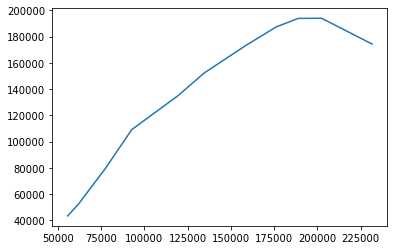

In [157]:
plt.plot(xrl50[0], yrl50[0], '-', label='Global RRT*')
# len(locbandrrt50[0])


# Day reverse arg

In [712]:
s1x, s1y = mp2(lons.values[50], lats.values[28])
s2x, s2y = mp2(lons.values[39], lats.values[33])
g1x, g1y = mp2(lons.values[12], lats.values[7])

r = 5

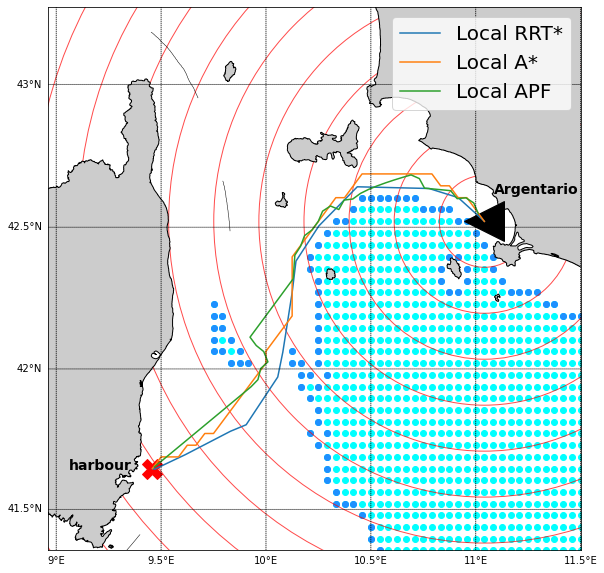

In [722]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, "<k", markersize=40)
mp2.plot(g1x, g1y, "X", color='red', markersize=20)  # saddlebrown
plt.text(g1x-11000, g1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(s1x+5000, s1y+13000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[r], yrs1[r], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[r], asumy1_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs1[r], yapfs1[r], '-', label='Sum APF')
# mp2.plot(xrg50[r], yrg50[r], '-', label='Global RRT*')
# mp2.plot(xag50[r], yag50[r], '-', label='Global A*')
# mp2.plot(xapfg50[r], yapfg50[r], '-', label='Global APF')
# mp2.plot(xrlist50[r], yrlist50[r], 'xk', markersize=5, label='Re-planning way-points')
# mp2.plot(xalist50[r], yalist50[r], 'xk', markersize=5)
# mp2.plot(xapflist50[r], yapflist50[r], 'xk', markersize=5)
# mp2.plot(xapflist50[r][-1], yapflist50[r][-1], 'Pr', markersize=15,markeredgecolor='k')
# mp2.plot(xrlist50[r][-1], yrlist50[r][-1], 'Pr', markersize=15,markeredgecolor='k')
# mp2.plot(xalist50[r][-1], yalist50[r][-1], 'Pr', markersize=15,markeredgecolor='k')
# mp2.plot(xrl50[r], yrl50[r], '-', label='Local RRT*')
plt.plot([x for (x, y) in pathstar6loc], [y for (x, y) in pathstar6loc], '-', label='Local RRT*')
# mp2.plot(pathstar6loc[r], yrl50[r], '-', label='Local RRT*')
mp2.plot(xal50[r], yal50[r], '-', label='Local A*')
mp2.plot(xapfl50[r], yapfl50[r], '-', label='Local APF')
# for i in range(le-li-4):
#     plt.pcolormesh(x, y, cost[i], cmap=my_cmap)
# for i in range(le-li-4):
#     mp2.scatter(x_obsm_[i], y_obsm_[i], ".", linewidth="1")
# for i in range(le-li-5):
#     plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.3-i*0.05)
# for i in range(le-li-5):
#     plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# plt.pcolor(x, y, cost[k], cmap=ListedColormap(['white', 'aqua']),alpha=0.6)
# plt.scatter(x_obsm_[k], y_obsm_[k], color="dodgerblue")
plt.scatter(map_x_, map_y_, color="aqua")
plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_, oymeteo_, color="aqua")
# plt.scatter(x_obsm_, y_obsm_, color="dodgerblue")
#plt.scatter(x_obsl_, y_obsl_, color="peru")


for i in range(le-li):
    ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
                                color='red', alpha=0.7, fill = False))
    
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
mp2.fillcontinents()
ax.legend(prop={"size":20}, loc="upper right", markerscale=1)
mp2.drawcoastlines()
mp2.drawstates() 
mp2.drawcountries()
plt.savefig('day6revlvera.png', dpi=300, bbox_inches='tight')
plt.show()

# Day reverse elba

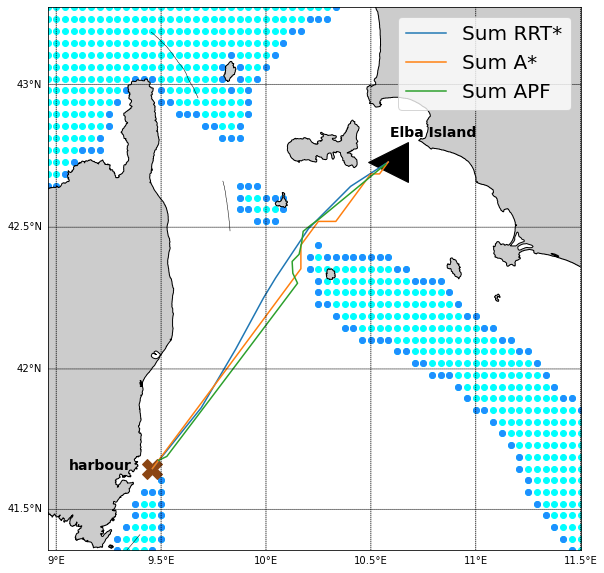

In [669]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s2x, s2y, "<k", markersize=40)
mp2.plot(g1x, g1y, "X", color='saddlebrown', markersize=20)
plt.text(g1x-11000, g1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(s2x+1000, s2y+12000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
mp2.plot(xrs2[r], yrs2[r], '-', label='Sum RRT*')
mp2.plot(asumx2_mp2[r], asumy2_mp2[r], '-', label='Sum A*')
mp2.plot(xapfs2[r], yapfs2[r], '-', label='Sum APF')
# mp2.plot(xrg39[r], yrg39[r], '-', label='Global RRT*')
# mp2.plot(xag39[r], yag39[r], '-', label='Global A*')
# mp2.plot(xrlist39[r], yrlist39[r], 'xk', markersize=5)
# mp2.plot(xalist39[r], yalist39[r], 'xk', markersize=5)
# mp2.plot(xapfg39[r], yapfg39[r], '-', label='Global APF')
# mp2.plot(xapflist39[r], yapflist39[r], 'xk', markersize=5, label='Re-planning way-points')
# mp2.plot(xapflist39[r][-1], yapflist39[r][-1], 'Pr', markersize=15,markeredgecolor='k')
# mp2.plot(xrlist39[r][-1], yrlist39[r][-1], 'Pr', markersize=15,markeredgecolor='k')
# mp2.plot(xalist39[r][-1], yalist39[r][-1], 'Pr', markersize=15,markeredgecolor='k')
# for i in range(le-li-5):
#     plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.3-i*0.05)
# for i in range(le-li-5):
#     plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 
# mp2.plot(xrl39[r], yrl39[r], '-', label='Local RRT*')
# mp2.plot(xal39[r], yal39[r], '-', label='Local A*')
# mp2.plot(xapfl39[r], yapfl39[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
plt.scatter(oxmeteo_, oymeteo_, color="aqua")
plt.scatter(x_obsm_, y_obsm_, color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))

# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s2x, s2y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False))
    
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day12revs2.png', dpi=300, bbox_inches='tight')
plt.show()

# Day1

## Survey1

In [673]:
ymax_vera = distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[0],lats.values[-1]))).m
xmax_vera = distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[-1],lats.values[0]))).m
print(xmax_vera, ymax_vera)

xmax_mp, ymax_mp = mp2(lons.values[-1],lats.values[-1])

print(xmax_mp, ymax_mp)

print(18000 / (ymax_vera / ymax_mp))
print(18000 / (xmax_vera / xmax_mp))

hh = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[0],lats.values[-1]))).m / mp2(lons.values[-1],lats.values[-1])[1])
ww = 18000 / (distance(lonlat(*(lons.values[0],lats.values[0])), lonlat(*(lons.values[-1],lats.values[0]))).m / mp2(lons.values[-1],lats.values[-1])[0])

print(hh, ww)

212687.23585215205 212901.83571540922
282620.34082146327 288240.94636369497
24369.62094343742
23918.5304863459
24369.62094343742 23918.5304863459


In [352]:
cmap = ListedColormap(['white', 'dodgerblue'])
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)

In [674]:
colorbar

['blue',
 'dodgerblue',
 'aqua',
 'springgreen',
 'forestgreen',
 'darkgoldenrod',
 'orange',
 'red',
 'darkred',
 'black']

NameError: name 'xrg1' is not defined

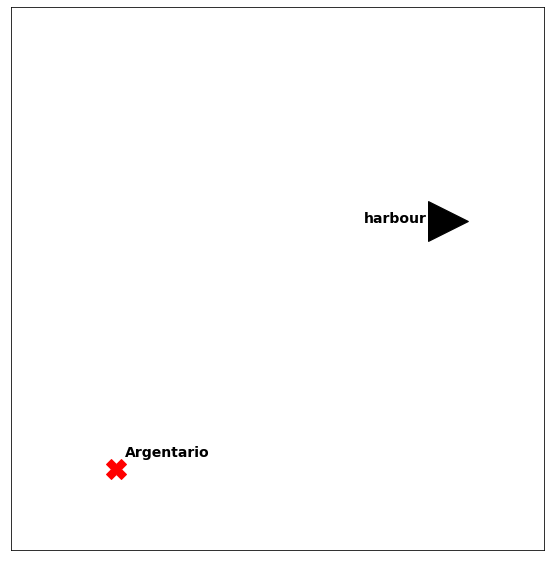

In [675]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g1x, g1y, "Xr", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x+5000, g1y+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[0], yrs1[0], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[0], asumy1_mp2[0], '-', label='Sum A*')
# mp2.plot(xapfs1[0], xapfs1[0], '-', label='Sum APF')
mp2.plot(xrg1[0], yrg1[0], '-', label='Global RRT*')
mp2.plot(xag1[0], yag1[0], '-', label='Global A*')
mp2.plot(xapfg1[0], yapfg1[0], '-', label='Global APF')
mp2.plot(xrlist1[0], yrlist1[0], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xalist1[0], yalist1[0], 'xk', markersize=5)
mp2.plot(xapflist1[0], yapflist1[0], 'xk', markersize=5)
# mp2.plot(xrl1[0], yrl1[0], '-', label='Local RRT*')
# mp2.plot(xal1[0], yal1[0], '-', label='Local A*')
# mp2.plot(xapfl1[0], yapfl1[0], '-', label='Local APF')
# for i in range(le-li-4):
#     plt.pcolormesh(x, y, cost[i], cmap=my_cmap)
# for i in range(le-li-4):
#     mp2.scatter(x_obsm_[i], y_obsm_[i], ".", linewidth="1")
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# plt.pcolor(x, y, cost[k], cmap=ListedColormap(['white', 'aqua']),alpha=0.6)
# plt.scatter(x_obsm_[k], y_obsm_[k], color="dodgerblue")
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_[0], oymeteo_[0], color="aqua")
# plt.scatter(x_obsm_[0], y_obsm_[0], color="dodgerblue")
#plt.scatter(x_obsl_, y_obsl_, color="peru")


# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False))
    
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
mp2.fillcontinents()
ax.legend(prop={"size":20}, loc="upper right", markerscale=1)
mp2.drawcoastlines()
mp2.drawstates() 
mp2.drawcountries()
# plt.savefig('day9gnew.png', dpi=300, bbox_inches='tight')
plt.show()

In [368]:
# listarandx = [[] for i in range(len(x_obsm))]
# listarandy = [[] for i in range(len(x_obsm))]
# for i in range(len(x_obsm)):
#     for j in range(len(x_obsm[i])):
#         listarandx[i].append(x_obsm)
        

## Survey 2

<ipython-input-692-dde60212ac15>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
<ipython-input-692-dde60212ac15>:22: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


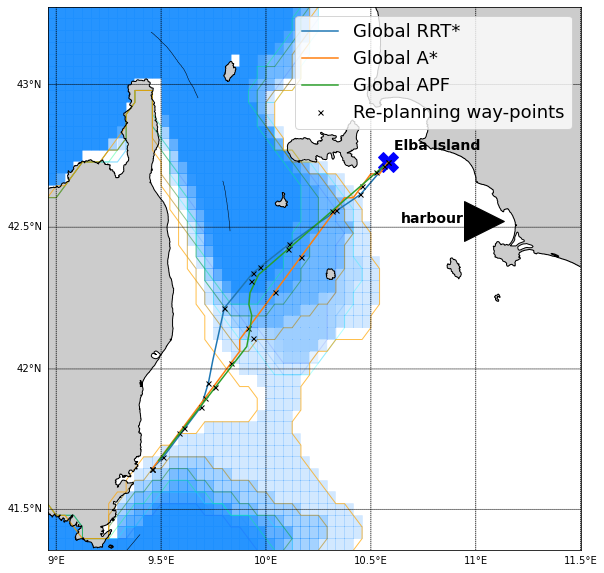

In [692]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g2x, g2y, "Xb", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g2x+3000, g2y+5000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs2[0], yrs2[0], '-', label='Sum RRT*')
# mp2.plot(asumx2_mp2[0], asumy2_mp2[0], '-', label='Sum A*')
# mp2.plot(xapfs1[0], xapfs1[0], '-', label='Sum APF')
mp2.plot(xrg2[0], yrg2[0], '-', label='Global RRT*')
mp2.plot(xag2[0], yag2[0], '-', label='Global A*')

mp2.plot(xrlist2[0], yrlist2[0], 'xk', markersize=5)
mp2.plot(xalist2[0], yalist2[0], 'xk', markersize=5)
mp2.plot(xapfg2[0], yapfg2[0], '-', label='Global APF')
mp2.plot(xapflist2[0], yapflist2[0], 'xk', markersize=5, label='Re-planning way-points')
# mp2.plot(xrl2[0], yrl2[0], '-', label='Local RRT*')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 
# mp2.plot(xal2[0], yal2[0], '-', label='Local A*')
# mp2.plot(xapfl2[0], yapfl2[0], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_, oymeteo_, color="aqua")
# plt.scatter(x_obsm_, y_obsm_, color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))

# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False))
    
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":18}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
# plt.savefig('day9_2g.png', dpi=300, bbox_inches='tight')
plt.show()

In [373]:
# fig,ax = plt.subplots(1)
# ax.set_aspect('equal')

# # The data array
# m1 = np.random.rand(5,5)
# # The alpha array. Normalize your map2 to the range 0,1
# m2 = np.linspace(0,1,25).reshape(5,5) 

# p = ax.pcolormesh(m1)
# # plt.savefig('myfig.png') # or fig.canvas.draw()

# for i,j in zip(p.get_facecolors(),m2.flatten()):
#     print(i)
#     i[3] = j # Set the alpha value of the RGBA tuple using m2

# # plt.savefig('myfig.png')

# Day2

## Survey1

<ipython-input-525-f92d5bf2447f>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
<ipython-input-525-f92d5bf2447f>:21: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


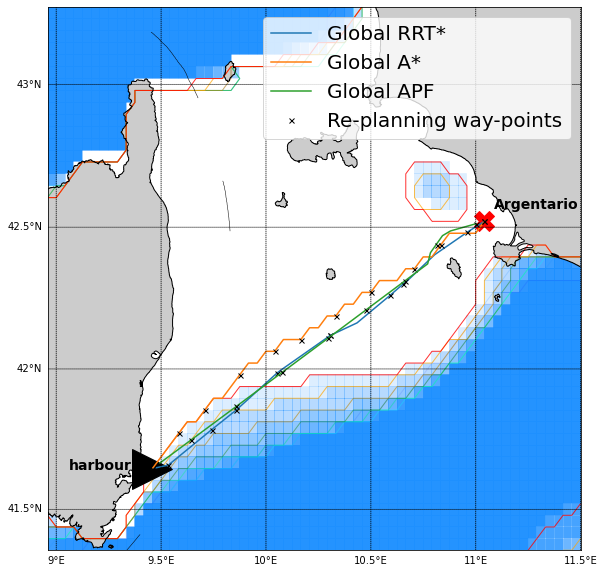

In [525]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g1x, g1y, "Xr", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x+5000, g1y+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[1], yrs1[1], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[1], asumy1_mp2[1], '-', label='Sum A*')
# mp2.plot(xapfs1[1], yapfs1[1], '-', label='Sum APF')
mp2.plot(xrg1[1], yrg1[1], '-', label='Global RRT*')
mp2.plot(xag1[1], yag1[1], '-', label='Global A*')
mp2.plot(xrlist1[1], yrlist1[1], 'xk', markersize=5)
mp2.plot(xalist1[1], yalist1[1], 'xk', markersize=5)
mp2.plot(xapfg1[1], yapfg1[1], '-', label='Global APF')
mp2.plot(xapflist1[1], yapflist1[1], 'xk', markersize=5, label='Re-planning way-points')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
    
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl1[1], yrl1[1], '-', label='Local RRT*')
# mp2.plot(xal1[1], yal1[1], '-', label='Local A*')
# mp2.plot(xapfl1[1], yapfl1[1], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_, oymeteo_, color="aqua")
# plt.scatter(x_obsm_, y_obsm_, color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False))    
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day2g.png', dpi=300, bbox_inches='tight')
plt.show()

## Survey2

<ipython-input-527-a5fcd7bdd5e9>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
<ipython-input-527-a5fcd7bdd5e9>:20: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


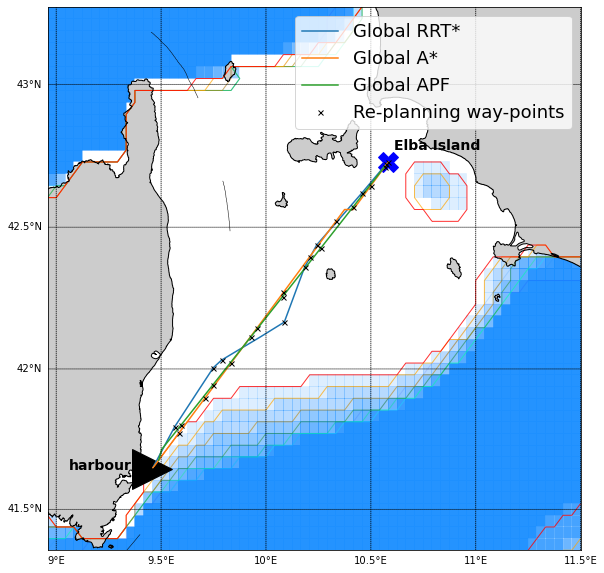

In [527]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g2x, g2y, "Xb", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g2x+3000, g2y+5000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs2[1], yrs2[1], '-', label='Sum RRT*')
# mp2.plot(asumx2_mp2[1], asumy2_mp2[1], '-', label='Sum A*')
# mp2.plot(xapfs2[1], yapfs2[1], '-', label='Sum APF')
mp2.plot(xrg2[1], yrg2[1], '-', label='Global RRT*')
mp2.plot(xag2[1], yag2[1], '-', label='Global A*')
mp2.plot(xapfg2[1], yapfg2[1], '-', label='Global APF')
mp2.plot(xapflist2[1], yapflist2[1], 'xk', markersize=5)
mp2.plot(xrlist2[1], yrlist2[1], 'xk', markersize=5)
mp2.plot(xalist2[1], yalist2[1], 'xk', markersize=5, label='Re-planning way-points')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl2[1], yrl2[1], '-', label='Local RRT*')
# mp2.plot(xal2[1], yal2[1], '-', label='Local A*')
# mp2.plot(xapfl2[1], yapfl2[1], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_, oymeteo_, color="aqua")
# plt.scatter(x_obsm_, y_obsm_, color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))

# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":18}, loc="upper right")
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day2_2g.png', dpi=300, bbox_inches='tight')
plt.show()

# Day3

## Survey1 

In [324]:
colorbar = ["blue", "dodgerblue", "aqua", "springgreen", "forestgreen", "darkgoldenrod", "orange", "red", "darkred", "black"]

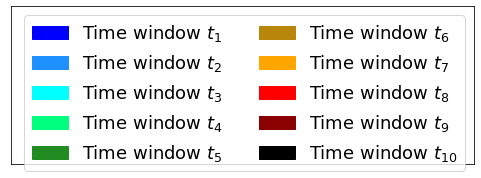

In [583]:
all_patch = ["" for i in range(len(colorbar))]
for i in range(len(colorbar)):
    all_patch[i] = pltpat.Patch(color=colorbar[i], label='Time window $t_{'+ str(i+1) + '}$')
fig, ax = plt.subplots(1, 1, figsize=(8.3, 2.9))
ax.legend(handles=all_patch, fontsize=18,ncol=2)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("legendglobal.png", dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-541-fabb7e953a1e>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
<ipython-input-541-fabb7e953a1e>:20: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


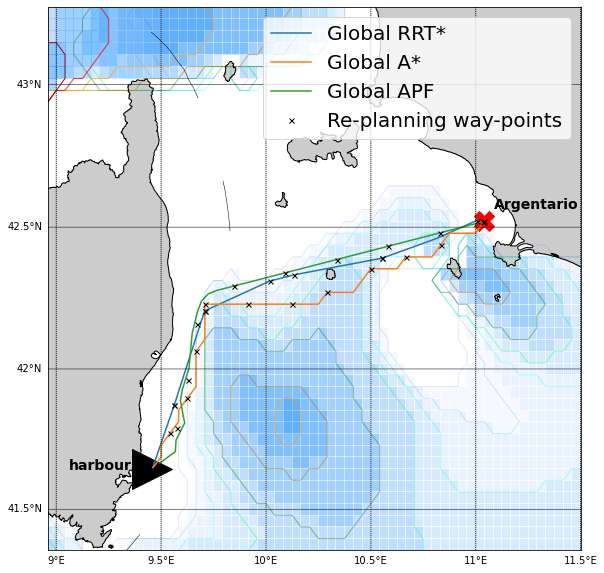

In [541]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g1x, g1y, "Xr", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x+5000, g1y+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[2], yrs1[2], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[2], asumy1_mp2[2], '-', label='Sum A*')
# mp2.plot(xapfs1[2], yapfs1[2], '-', label='Sum APF')
mp2.plot(xrg1[2], yrg1[2], '-', label='Global RRT*')
mp2.plot(xag1[2], yag1[2], '-', label='Global A*')
mp2.plot(xapfg1[2], yapfg1[2], '-', label='Global APF')
mp2.plot(xapflist1[2], yapflist1[2], 'xk', markersize=5)
mp2.plot(xrlist1[2], yrlist1[2], 'xk', markersize=5)
mp2.plot(xalist1[2], yalist1[2], 'xk', markersize=5, label='Re-planning way-points')
for i in range(le-li-4):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-4):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 
# plt.pcolor(x, y, cost[0], cmap=ListedColormap(['white', 'red']), alpha=0.5)
# plt.pcolor(x, y, cost[1], cmap=ListedColormap(['white', 'orange']), alpha=0.5)
# plt.pcolor(x, y, cost[2], cmap=ListedColormap(['white', 'yellow']), alpha=0.5)
# plt.pcolor(x, y, cost[3], cmap=ListedColormap(['white', 'green']), alpha=0.5)
# plt.pcolor(x, y, cost[4], cmap=ListedColormap(['white', 'aqua']), alpha=0.5)
# plt.pcolor(x, y, cost[5], cmap=ListedColormap(['white', 'dodgerblue']), alpha=0.5)
# plt.pcolor(x, y, cost[6], cmap=ListedColormap(['white', 'violet']), alpha=0.5)
# mp2.plot(xrl1[2], yrl1[2], '-', label='Local RRT*')
# mp2.plot(xal1[2], yal1[2], '-', label='Local A*')
# mp2.plot(xapfl1[2], yapfl1[2], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_, oymeteo_, color="aqua")
# plt.scatter(x_obsm_, y_obsm_, color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False))     
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day3g.png', dpi=300, bbox_inches='tight')
plt.show()

## Survey2

<ipython-input-544-0d726462b04f>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
<ipython-input-544-0d726462b04f>:20: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


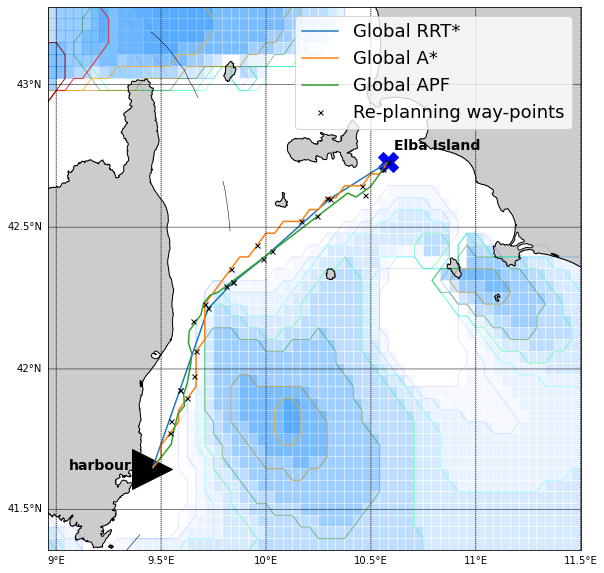

In [544]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g2x, g2y, "Xb", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g2x+3000, g2y+5000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs2[2], yrs2[2], '-', label='Sum RRT*')
# mp2.plot(asumx2_mp2[2], asumy2_mp2[2], '-', label='Sum A*')
# mp2.plot(xapfs2[2], yapfs2[2], '-', label='Sum APF')
mp2.plot(xrg2[2], yrg2[2], '-', label='Global RRT*')
mp2.plot(xag2[2], yag2[2], '-', label='Global A*')
mp2.plot(xapfg2[2], yapfg2[2], '-', label='Global APF')
mp2.plot(xapflist2[2], yapflist2[2], 'xk', markersize=5)
mp2.plot(xrlist2[2], yrlist2[2], 'xk', markersize=5)
mp2.plot(xalist2[2], yalist2[2], 'xk', markersize=5, label='Re-planning way-points')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl2[2], yrl2[2], '-', label='Local RRT*')
# mp2.plot(xal2[2], yal2[2], '-', label='Local A*')
# mp2.plot(xapfl2[2], yapfl2[2], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_, oymeteo_, color="aqua")
# plt.scatter(x_obsm_, y_obsm_, color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False))     
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":18}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day3_2g.png', dpi=300, bbox_inches='tight')
plt.show()

# Day4

## Survey1 

<ipython-input-549-d49c3557085a>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
<ipython-input-549-d49c3557085a>:23: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


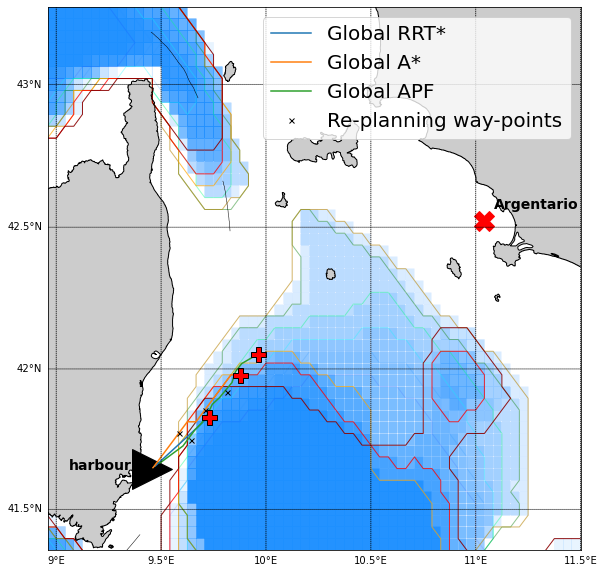

In [549]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g1x, g1y, "Xr", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x+5000, g1y+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[3], yrs1[3], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[3], asumy1_mp2[3], '-', label='Sum A*')
# mp2.plot(xapfs1[3], yapfs1[3], '-', label='Sum APF')
mp2.plot(xrg1[3], yrg1[3], '-', label='Global RRT*')
mp2.plot(xag1[3], yag1[3], '-', label='Global A*')
mp2.plot(xapfg1[3], yapfg1[3], '-', label='Global APF')
mp2.plot(xapflist1[3], yapflist1[3], 'xk', markersize=5)
mp2.plot(xrlist1[3], yrlist1[3], 'xk', markersize=5)
mp2.plot(xalist1[3], yalist1[3], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xapflist1[3][-1], yapflist1[3][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xrlist1[3][-1], yrlist1[3][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xalist1[3][-1], yalist1[3][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl1[3], yrl1[3], '-', label='Local RRT*')
# mp2.plot(xal1[3], yal1[3], '-', label='Local A*')
# mp2.plot(xapfl1[3], yapfl1[3], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_[4], oymeteo_[4], color="aqua")
# plt.scatter(x_obsm_[4], y_obsm_[4], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day4g.png', dpi=300, bbox_inches='tight')
plt.show()

## Survey2 

In [104]:
apf4x = []
apf4y = []
apf4xlist = []
apf4ylist = []

In [105]:
apf4x = []
apf4y = []
apf4xlist = []
apf4ylist = []
for i in range(len(gloapf2neww[3][0])):
    temp, temp2 = mp2(gloapf2neww[3][0][i], gloapf2neww[3][1][i])
    apf4x.append(temp)
    apf4y.append(temp2)
    
for i in range(len(apf_list_s2neww[3][0])):
    temp, temp2 = mp2(apf_list_s2neww[3][0][i], apf_list_s2neww[3][1][i])
    apf4xlist.append(temp)
    apf4ylist.append(temp2)

<ipython-input-108-09324547fcd3>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
<ipython-input-108-09324547fcd3>:25: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


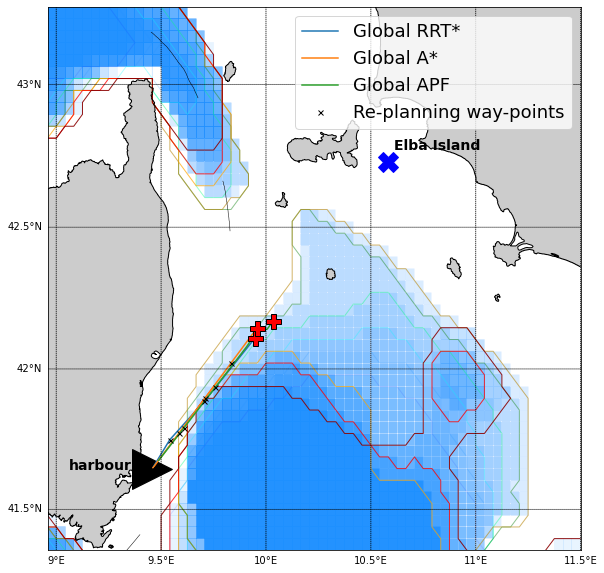

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g2x, g2y, "Xb", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g2x+3000, g2y+5000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs2[3], yrs2[3], '-', label='Sum RRT*')
# mp2.plot(asumx2_mp2[3], asumy2_mp2[3], '-', label='Sum A*')
# mp2.plot(xapfs2[3], yapfs2[3], '-', label='Sum APF')
mp2.plot(xrg2[3], yrg2[3], '-', label='Global RRT*')
mp2.plot(xag2[3], yag2[3], '-', label='Global A*')
# mp2.plot(xapfg2[3], yapfg2[3], '-', label='Global APF')
# mp2.plot(xapflist2[3], yapflist2[3], 'xk', markersize=5)
mp2.plot(apf4x, apf4y, '-', label='Global APF')
mp2.plot(apf4xlist, apf4ylist, 'xk', markersize=5)
mp2.plot(apf4xlist[-1], apf4ylist[-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xrlist2[3], yrlist2[3], 'xk', markersize=5)
mp2.plot(xalist2[3], yalist2[3], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xrlist2[3][-1], yrlist2[3][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xalist2[3][-1], yalist2[3][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl2[3], yrl2[3], '-', label='Local RRT*')
# mp2.plot(xal2[3], yal2[3], '-', label='Local A*')
# mp2.plot(xapfl2[3], yapfl2[3], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_[4], oymeteo_[4], color="aqua")
# plt.scatter(x_obsm_[4], y_obsm_[4], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":18}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day4_2gnew.png', dpi=300, bbox_inches='tight')
plt.show()

# Day5

## Survey1 

In [128]:
apf4x = []
apf4y = []
apf4xlist = []
apf4ylist = []
for i in range(len(glorrt1neww[4][0])):
    temp, temp2 = mp2(glorrt1neww[4][0][i], glorrt1neww[4][1][i])
    apf4x.append(temp)
    apf4y.append(temp2)
    
for i in range(len(rrt_list_s1neww[4][0])):
    temp, temp2 = mp2(rrt_list_s1neww[4][0][i], rrt_list_s1neww[4][1][i])
    apf4xlist.append(temp)
    apf4ylist.append(temp2)

<ipython-input-135-a43c50be608e>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.6-i*0.05)
<ipython-input-135-a43c50be608e>:24: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


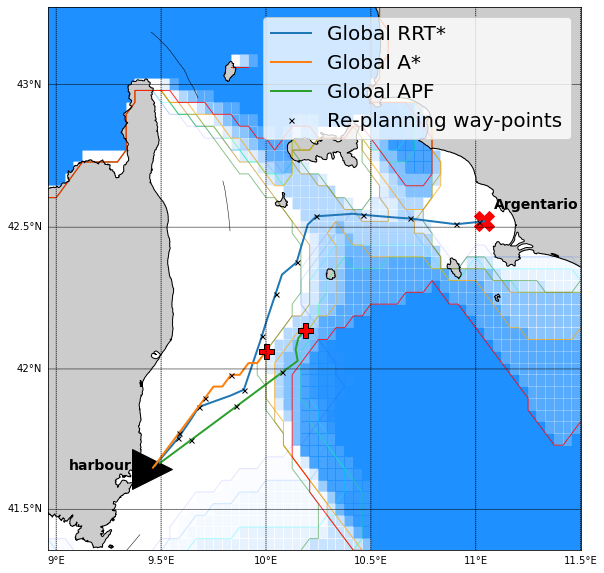

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g1x, g1y, "Xr", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x+5000, g1y+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[4], yrs1[4], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[4], asumy1_mp2[4], '-', label='Sum A*')
# mp2.plot(xapfs1[4], yapfs1[4], '-', label='Sum APF')
# mp2.plot(xrg1[4], yrg1[4], '-', label='Global RRT*', linewidth=2)
mp2.plot(apf4x, apf4y, '-', label='Global RRT*', linewidth=2)
mp2.plot(apf4xlist, apf4ylist, 'xk', markersize=5)
mp2.plot(xag1[4], yag1[4], '-', label='Global A*', linewidth=2)
mp2.plot(xapfg1[4], yapfg1[4], '-', label='Global APF', linewidth=2)
mp2.plot(xapflist1[4], yapflist1[4], 'xk', markersize=5)
# mp2.plot(xrlist1[4], yrlist1[4], 'xk', markersize=5)
mp2.plot(xalist1[4], yalist1[4], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xalist1[4][-1], yalist1[4][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xapflist1[4][-1], yapflist1[4][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.6-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl1[4], yrl1[4], '-', label='Local RRT*')
# mp2.plot(xal1[4], yal1[4], '-', label='Local A*')
# mp2.plot(xapfl1[4], yapfl1[4], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_[4], oymeteo_[4], color="aqua")
# plt.scatter(x_obsm_[4], y_obsm_[4], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day5gnew.png', dpi=300, bbox_inches='tight')
plt.show()

## Survey2

In [139]:
apf4x

[55588.54155239776,
 60220.9200150976,
 64853.29847779745,
 69485.6769404973,
 74118.05540319714,
 78750.433865897,
 83382.81232859683,
 88015.19079129648,
 92647.56925399633,
 97279.94771669617,
 101912.32617939603,
 106544.70464209586,
 111177.08310479572,
 115809.46156749537,
 120441.8400301952,
 125074.21849289506,
 129706.5969555949,
 134338.97541829475,
 138971.3538809946,
 143603.73234369443]

In [213]:
apf4x = []
apf4y = []
apf4xlist = []
apf4ylist = []
for i in range(len(glopatha2neww[4][0])):
    temp, temp2 = mp2(glopatha2neww[4][0][i], glopatha2neww[4][1][i])
    apf4x.append(temp)
    apf4y.append(temp2)
    
for i in range(len(ast_list_s2neww[4][0])):
    temp, temp2 = mp2(ast_list_s2neww[4][0][i], ast_list_s2neww[4][1][i])
    apf4xlist.append(temp)
    apf4ylist.append(temp2)

<ipython-input-215-ccc893dd5011>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.6-i*0.05)
<ipython-input-215-ccc893dd5011>:27: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


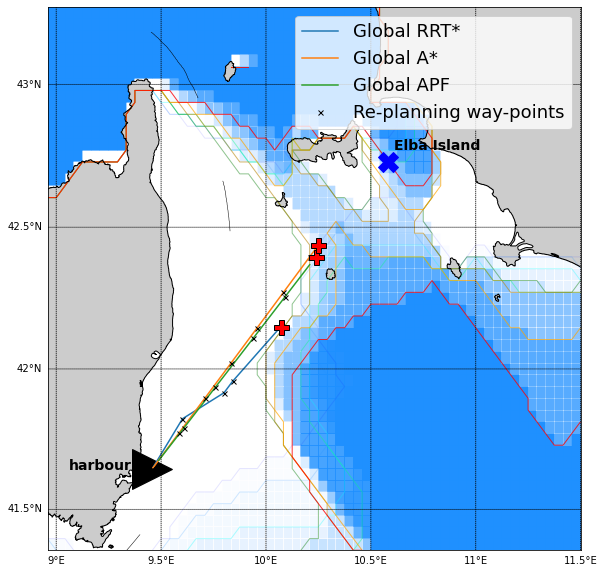

In [215]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g2x, g2y, "Xb", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g2x+3000, g2y+5000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs2[4], yrs2[4], '-', label='Sum RRT*')
# mp2.plot(asumx2_mp2[4], asumy2_mp2[4], '-', label='Sum A*')
# mp2.plot(xapfs2[4], yapfs2[4], '-', label='Sum APF')

mp2.plot(xrg2[4], yrg2[4], '-', label='Global RRT*')
# mp2.plot(xag2[4], yag2[4], '-', label='Global A*')
mp2.plot(apf4x, apf4y, '-', label='Global A*')

mp2.plot(xapfg2[4], yapfg2[4], '-', label='Global APF')
mp2.plot(apf4xlist, apf4ylist, 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xapflist2[4], yapflist2[4], 'xk', markersize=5)
mp2.plot(xrlist2[4], yrlist2[4], 'xk', markersize=5)
# mp2.plot(xalist2[4], yalist2[4], 'xk', markersize=5)
mp2.plot(xapflist2[4][-1], yapflist2[4][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xrlist2[4][-1], yrlist2[4][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(apf4xlist[-1], apf4ylist[-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.6-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl2[4], yrl2[4], '-', label='Local RRT*')
# mp2.plot(xal2[4], yal2[4], '-', label='Local A*')
# mp2.plot(xapfl2[4], yapfl2[4], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_[4], oymeteo_[4], color="aqua")
# plt.scatter(x_obsm_[4], y_obsm_[4], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":18}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day5_2gnew.png', dpi=300, bbox_inches='tight')
plt.show()

# Day6

## Survey1

In [145]:
apf4x = []
apf4y = []
apf4xlist = []
apf4ylist = []
for i in range(len(glorrt1neww[5][0])):
    temp, temp2 = mp2(glorrt1neww[5][0][i], glorrt1neww[5][1][i])
    apf4x.append(temp)
    apf4y.append(temp2)
    
for i in range(len(rrt_list_s1neww[5][0])):
    temp, temp2 = mp2(rrt_list_s1neww[5][0][i], rrt_list_s1neww[5][1][i])
    apf4xlist.append(temp)
    apf4ylist.append(temp2)

<ipython-input-160-578b6df5eb29>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
<ipython-input-160-578b6df5eb29>:26: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.2+i*0.1)    # le più recenti


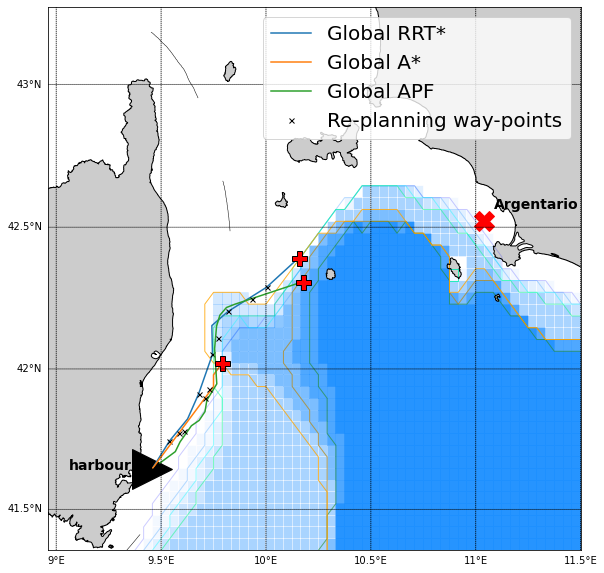

In [160]:
r = 5
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g1x, g1y, "Xr", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x+5000, g1y+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[r], yrs1[r], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[r], asumy1_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs1[r], yapfs1[r], '-', label='Sum APF')
mp2.plot(apf4x, apf4y, '-', label='Global RRT*')
mp2.plot(apf4xlist, apf4ylist, 'xk', markersize=5)
# mp2.plot(xrg1[r], yrg1[r], '-', label='Global RRT*')
mp2.plot(xag1[r], yag1[r], '-', label='Global A*')
mp2.plot(xapfg1[r], yapfg1[r], '-', label='Global APF')
mp2.plot(xapflist1[r], yapflist1[r], 'xk', markersize=5)
# mp2.plot(xrlist1[r], yrlist1[r], 'xk', markersize=5)
mp2.plot(xalist1[r], yalist1[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xalist1[r][-1], yalist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xapflist1[r][-1], yapflist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(apf4xlist[-1], apf4ylist[-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.2+i*0.1)    # le più recenti 

# mp2.plot(xrl1[r], yrl1[r], '-', label='Local RRT*')
# mp2.plot(xal1[r], yal1[r], '-', label='Local A*')
# mp2.plot(xapfl1[r], yapfl1[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_[2], oymeteo_[2], color="aqua")
# plt.scatter(x_obsm_[2], y_obsm_[2], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day6gnew.png', dpi=300, bbox_inches='tight')
plt.show()

## Survey2

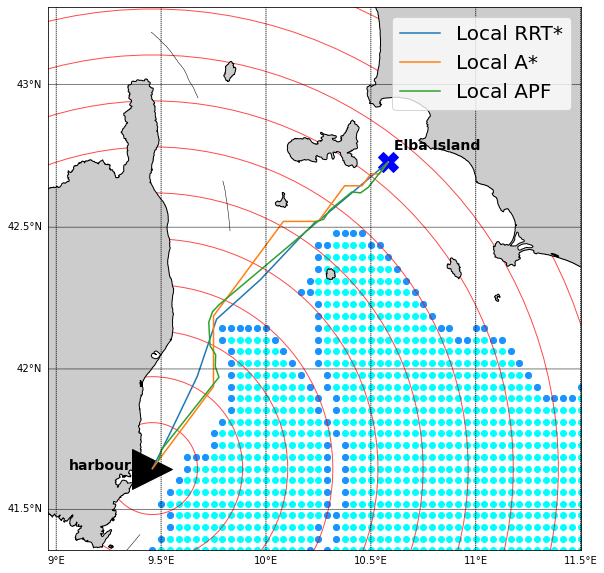

In [161]:
r = 5
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g2x, g2y, "Xb", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g2x+3000, g2y+5000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs2[r], yrs2[r], '-', label='Sum RRT*')
# mp2.plot(asumx2_mp2[r], asumy2_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs2[r], yapfs2[r], '-', label='Sum APF')
mp2.plot(xrg2[r], yrg2[r], '-', label='Global RRT*')
mp2.plot(xag2[r], yag2[r], '-', label='Global A*')
mp2.plot(xapfg2[r], yapfg2[r], '-', label='Global APF')
mp2.plot(xapflist2[r], yapflist2[r], 'xk', markersize=5)
mp2.plot(xrlist2[r], yrlist2[r], 'xk', markersize=5)
mp2.plot(xalist2[r], yalist2[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xapflist2[r][-1], yapflist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xrlist2[r][-1], yrlist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xalist2[r][-1], yalist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl2[r], yrl2[r], '-', label='Local RRT*')
# mp2.plot(xal2[r], yal2[r], '-', label='Local A*')
# mp2.plot(xapfl2[r], yapfl2[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_[3], oymeteo_[3], color="aqua")
# plt.scatter(x_obsm_[3], y_obsm_[3], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":18}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day6_2l.png', dpi=300, bbox_inches='tight')
plt.show()

# Day7

## Survey1

In [166]:
apf4x = []
apf4y = []
apf4xlist = []
apf4ylist = []
for i in range(len(gloapf1neww[6][0])):
    temp, temp2 = mp2(gloapf1neww[6][0][i], gloapf1neww[6][1][i])
    apf4x.append(temp)
    apf4y.append(temp2)
    
for i in range(len(apf_list_s1neww[6][0])):
    temp, temp2 = mp2(apf_list_s1neww[6][0][i], apf_list_s1neww[6][1][i])
    apf4xlist.append(temp)
    apf4ylist.append(temp2)

<ipython-input-175-fd4d5ed6c214>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.6-i*0.05)
<ipython-input-175-fd4d5ed6c214>:26: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


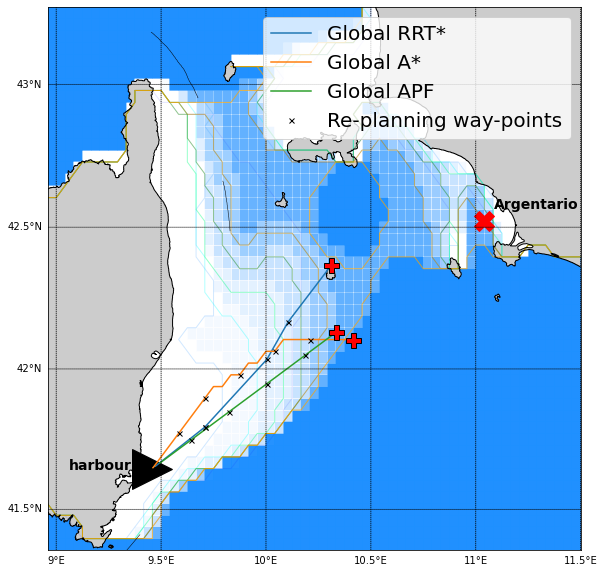

In [175]:
r = 6
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g1x, g1y, "Xr", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x+5000, g1y+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[r], yrs1[r], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[r], asumy1_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs1[r], yapfs1[r], '-', label='Sum APF')
mp2.plot(xrg1[r], yrg1[r], '-', label='Global RRT*')
mp2.plot(xag1[r], yag1[r], '-', label='Global A*')
mp2.plot(apf4x, apf4y, '-', label='Global APF')
mp2.plot(apf4xlist, apf4ylist, 'xk', markersize=5)
# mp2.plot(xapfg1[r], yapfg1[r], '-', label='Global APF')
# mp2.plot(xapflist1[r], yapflist1[r], 'xk', markersize=5)
mp2.plot(xrlist1[r], yrlist1[r], 'xk', markersize=5)
mp2.plot(xalist1[r], yalist1[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xrlist1[r][-1], yrlist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xalist1[r][-1], yalist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(apf4xlist[-1], apf4ylist[-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.6-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl1[r], yrl1[r], '-', label='Local RRT*')
# mp2.plot(xal1[r], yal1[r], '-', label='Local A*')
# mp2.plot(xapfl1[r], yapfl1[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
var = 5
# plt.scatter(oxmeteo_[var], oymeteo_[var], color="aqua")
# plt.scatter(x_obsm_[var], y_obsm_[var], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")

mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day7gnew.png', dpi=300, bbox_inches='tight')
plt.show()

## Survey2

In [189]:
apf4x = []
apf4y = []
apf4xlist = []
apf4ylist = []
for i in range(len(glorrt2neww[6][0])):
    temp, temp2 = mp2(glorrt2neww[6][0][i], glorrt2neww[6][1][i])
    apf4x.append(temp)
    apf4y.append(temp2)
    
for i in range(len(rrt_list_s2neww[6][0])):
    temp, temp2 = mp2(rrt_list_s2neww[6][0][i], rrt_list_s2neww[6][1][i])
    apf4xlist.append(temp)
    apf4ylist.append(temp2)

In [195]:
apf4x

[55597.43714234059,
 72656.21728184393,
 76958.00732765811,
 87852.35053006645,
 96900.93932943113,
 105209.29481901959,
 108022.20884913768,
 110568.63116848611,
 116851.62129016362,
 122256.50126532307,
 126444.63556608444,
 132566.74155484236,
 139023.4991650632,
 142330.17088824697,
 145148.82460724798]

<ipython-input-201-bf802e56009b>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.6-i*0.05)
<ipython-input-201-bf802e56009b>:25: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


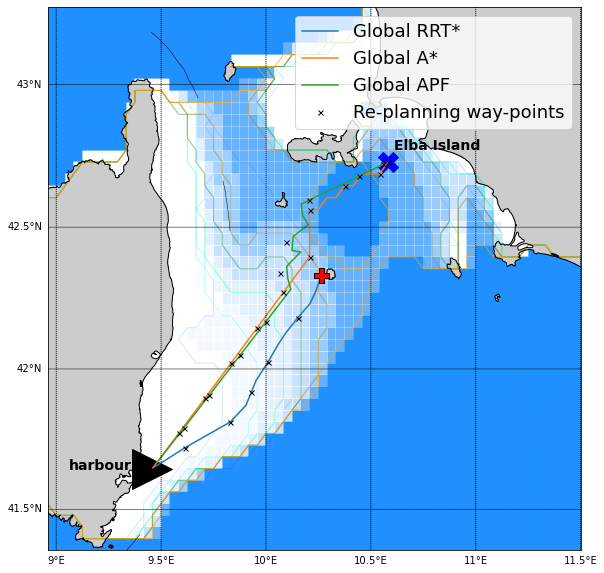

In [201]:
r = 6
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g2x, g2y, "Xb", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g2x+3000, g2y+5000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs2[r], yrs2[r], '-', label='Sum RRT*')
# mp2.plot(asumx2_mp2[r], asumy2_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs2[r], yapfs2[r], '-', label='Sum APF')
# mp2.plot(xrg2[r], yrg2[r], '-', label='Global RRT*')
mp2.plot(apf4x, apf4y, '-', label='Global RRT*')
mp2.plot(xag2[r], yag2[r], '-', label='Global A*')
mp2.plot(xapfg2[r], yapfg2[r], '-', label='Global APF')
mp2.plot(xapflist2[r], yapflist2[r], 'xk', markersize=5)
mp2.plot(apf4xlist[:7], apf4ylist[:7], 'xk', markersize=5)
mp2.plot(xalist2[r], yalist2[r], 'xk', markersize=5, label='Re-planning way-points')
# mp2.plot(xapflist2[r][-1], yapflist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(apf4xlist[6], apf4ylist[6], 'Pr', markersize=15,markeredgecolor='k')
# mp2.plot(xalist2[r][-1], yalist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.6-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl2[r], yrl2[r], '-', label='Local RRT*')
# mp2.plot(xal2[r], yal2[r], '-', label='Local A*')
# mp2.plot(xapfl2[r], yapfl2[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# plt.scatter(oxmeteo_[2], oymeteo_[2], color="aqua")
# plt.scatter(x_obsm_[2], y_obsm_[2], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":18}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day7_2gnew.png', dpi=300, bbox_inches='tight')
plt.show()

# Day8

## Survey1

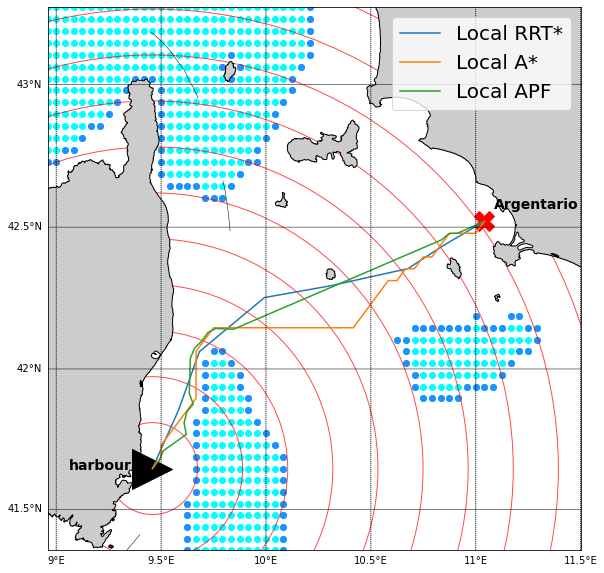

In [174]:
r = 7
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g1x, g1y, "Xr", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x+5000, g1y+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[r], yrs1[r], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[r], asumy1_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs1[r], yapfs1[r], '-', label='Sum APF')
mp2.plot(xrg1[r], yrg1[r], '-', label='Global RRT*')
mp2.plot(xag1[r], yag1[r], '-', label='Global A*')
mp2.plot(xapfg1[r], yapfg1[r], '-', label='Global APF')
mp2.plot(xapflist1[r], yapflist1[r], 'xk', markersize=5)
mp2.plot(xrlist1[r], yrlist1[r], 'xk', markersize=5)
mp2.plot(xalist1[r], yalist1[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xrlist1[r][-1], yrlist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xalist1[r][-1], yalist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xapflist1[r][-1], yapflist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl1[r], yrl1[r], '-', label='Local RRT*')
# mp2.plot(xal1[r], yal1[r], '-', label='Local A*')
# mp2.plot(xapfl1[r], yapfl1[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
var = 4
# plt.scatter(oxmeteo_[var], oymeteo_[var], color="aqua")
# plt.scatter(x_obsm_[var], y_obsm_[var], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
# plt.savefig('day8gnew.png', dpi=300, bbox_inches='tight')
plt.show()

## Survey2

<ipython-input-693-a6acb8084062>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
<ipython-input-693-a6acb8084062>:24: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


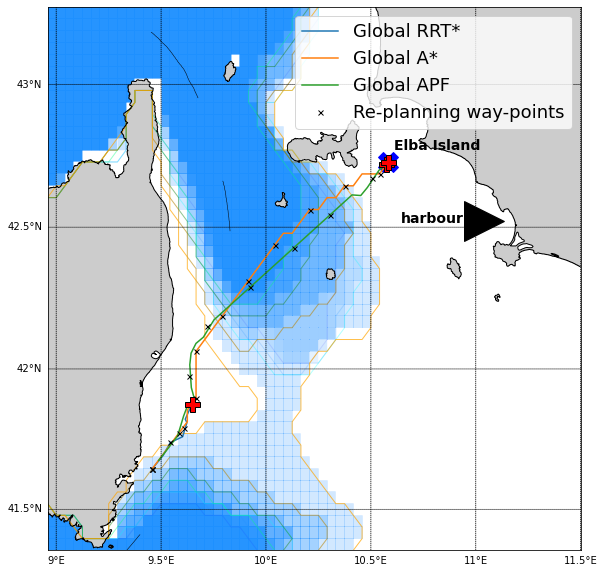

In [693]:
r = 7
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g2x, g2y, "Xb", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g2x+3000, g2y+5000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs2[r], yrs2[r], '-', label='Sum RRT*')
# mp2.plot(asumx2_mp2[r], asumy2_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs2[r], yapfs2[r], '-', label='Sum APF')
mp2.plot(xrg2[r], yrg2[r], '-', label='Global RRT*')
mp2.plot(xag2[r], yag2[r], '-', label='Global A*')
mp2.plot(xapfg2[r], yapfg2[r], '-', label='Global APF')
mp2.plot(xapflist2[r], yapflist2[r], 'xk', markersize=5)
mp2.plot(xrlist2[r], yrlist2[r], 'xk', markersize=5)
mp2.plot(xalist2[r], yalist2[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xapflist2[r][-1], yapflist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xrlist2[r][-1], yrlist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xalist2[r][-1], yalist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl2[r], yrl2[r], '-', label='Local RRT*')
# mp2.plot(xal2[r], yal2[r], '-', label='Local A*')
# mp2.plot(xapfl2[r], yapfl2[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
var=4
# plt.scatter(oxmeteo_[var], oymeteo_[var], color="aqua")
# plt.scatter(x_obsm_[var], y_obsm_[var], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":18}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
# plt.savefig('day9_2gnew.png', dpi=300, bbox_inches='tight')
plt.show()

# Day9

## Survey1

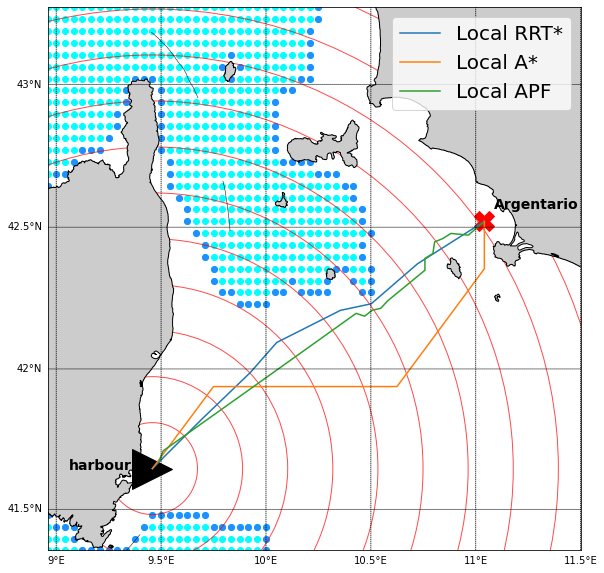

In [181]:
r = 8
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g1x, g1y, "Xr", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x+5000, g1y+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[r], yrs1[r], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[r], asumy1_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs1[r], yapfs1[r], '-', label='Sum APF')
mp2.plot(xrg1[r], yrg1[r], '-', label='Global RRT*')
mp2.plot(xag1[r], yag1[r], '-', label='Global A*')
mp2.plot(xapfg1[r], yapfg1[r], '-', label='Global APF')
mp2.plot(xapflist1[r], yapflist1[r], 'xk', markersize=5)
mp2.plot(xrlist1[r], yrlist1[r], 'xk', markersize=5)
mp2.plot(xalist1[r], yalist1[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xrlist1[r][-1], yrlist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xalist1[r][-1], yalist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xapflist1[r][-1], yapflist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl1[r], yrl1[r], '-', label='Local RRT*')
# mp2.plot(xal1[r], yal1[r], '-', label='Local A*')
# mp2.plot(xapfl1[r], yapfl1[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
var=6
# plt.scatter(oxmeteo_[var], oymeteo_[var], color="aqua")
# plt.scatter(x_obsm_[var], y_obsm_[var], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day9l.png', dpi=300, bbox_inches='tight')
plt.show()

## Survey2

<ipython-input-696-5c121f46a650>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
<ipython-input-696-5c121f46a650>:24: UserWarning: No contour levels were found within the data range.
  plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti


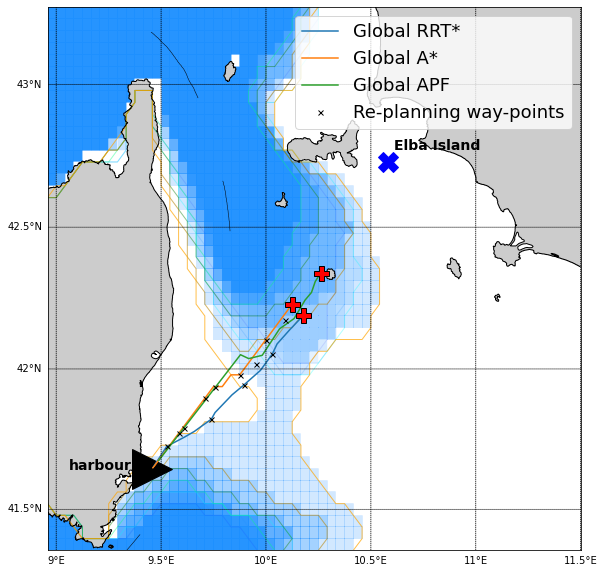

In [696]:
r = 8
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g2x, g2y, "Xb", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g2x+3000, g2y+5000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs2[r], yrs2[r], '-', label='Sum RRT*')
# mp2.plot(asumx2_mp2[r], asumy2_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs2[r], yapfs2[r], '-', label='Sum APF')
mp2.plot(xrg2[r], yrg2[r], '-', label='Global RRT*')
mp2.plot(xag2[r], yag2[r], '-', label='Global A*')
mp2.plot(xapfg2[r], yapfg2[r], '-', label='Global APF')
mp2.plot(xapflist2[r], yapflist2[r], 'xk', markersize=5)
mp2.plot(xrlist2[r], yrlist2[r], 'xk', markersize=5)
mp2.plot(xalist2[r], yalist2[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xapflist2[r][-1], yapflist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xrlist2[r][-1], yrlist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xalist2[r][-1], yalist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl2[r], yrl2[r], '-', label='Local RRT*')
# mp2.plot(xal2[r], yal2[r], '-', label='Local A*')
# mp2.plot(xapfl2[r], yapfl2[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
var=5
# plt.scatter(oxmeteo_[var], oymeteo_[var], color="aqua")
# plt.scatter(x_obsm_[var], y_obsm_[var], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":18}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day9_2gnew.png', dpi=300, bbox_inches='tight')
plt.show()

# Day10

## Survey1

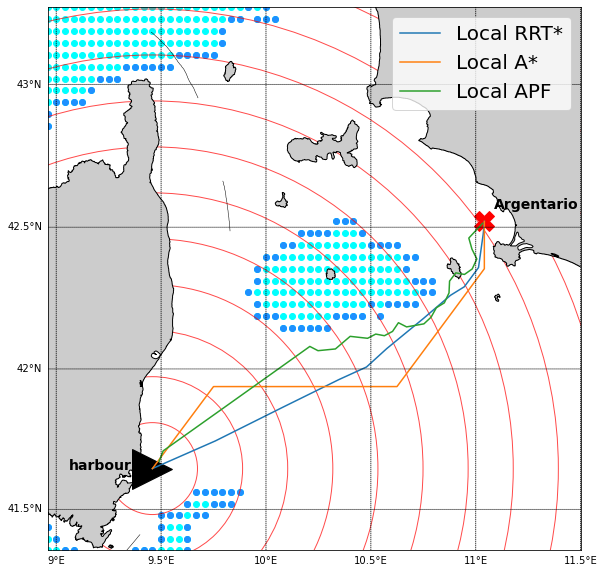

In [188]:
r = 9
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g1x, g1y, "Xr", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x+5000, g1y+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[r], yrs1[r], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[r], asumy1_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs1[r], yapfs1[r], '-', label='Sum APF')
mp2.plot(xrg1[r], yrg1[r], '-', label='Global RRT*')
mp2.plot(xag1[r], yag1[r], '-', label='Global A*')
mp2.plot(xapfg1[r], yapfg1[r], '-', label='Global APF')
mp2.plot(xapflist1[r], yapflist1[r], 'xk', markersize=5)
mp2.plot(xrlist1[r], yrlist1[r], 'xk', markersize=5)
mp2.plot(xalist1[r], yalist1[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xrlist1[r][-1], yrlist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xalist1[r][-1], yalist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xapflist1[r][-1], yapflist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl1[r], yrl1[r], '-', label='Local RRT*')
# mp2.plot(xal1[r], yal1[r], '-', label='Local A*')
# mp2.plot(xapfl1[r], yapfl1[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
var=6
# plt.scatter(oxmeteo_[var], oymeteo_[var], color="aqua")
# plt.scatter(x_obsm_[var], y_obsm_[var], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day10l.png', dpi=300, bbox_inches='tight')
plt.show()

## Survey2

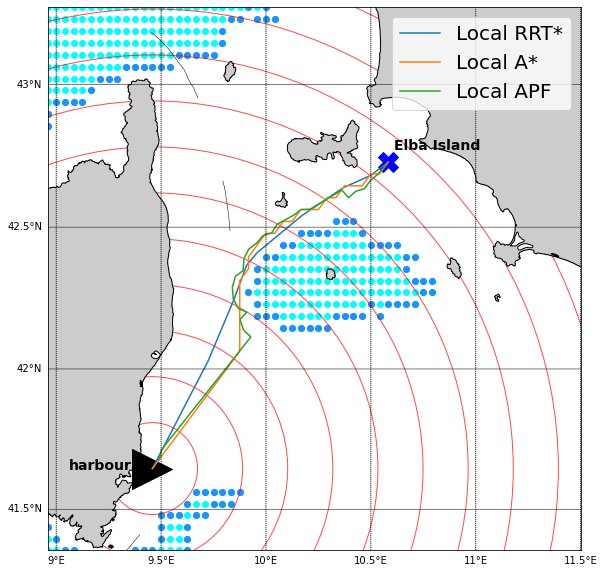

In [190]:
r = 9
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g2x, g2y, "Xb", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g2x+3000, g2y+5000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs2[r], yrs2[r], '-', label='Sum RRT*')
# mp2.plot(asumx2_mp2[r], asumy2_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs2[r], yapfs2[r], '-', label='Sum APF')
mp2.plot(xrg2[r], yrg2[r], '-', label='Global RRT*')
mp2.plot(xag2[r], yag2[r], '-', label='Global A*')
mp2.plot(xapfg2[r], yapfg2[r], '-', label='Global APF')
mp2.plot(xapflist2[r], yapflist2[r], 'xk', markersize=5)
mp2.plot(xrlist2[r], yrlist2[r], 'xk', markersize=5)
mp2.plot(xalist2[r], yalist2[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xapflist2[r][-1], yapflist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xrlist2[r][-1], yrlist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xalist2[r][-1], yalist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl2[r], yrl2[r], '-', label='Local RRT*')
# mp2.plot(xal2[r], yal2[r], '-', label='Local A*')
# mp2.plot(xapfl2[r], yapfl2[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
var=5
# plt.scatter(oxmeteo_[var], oymeteo_[var], color="aqua")
# plt.scatter(x_obsm_[var], y_obsm_[var], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":18}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day10_2l.png', dpi=300, bbox_inches='tight')
plt.show()

# Day11

## Survey1

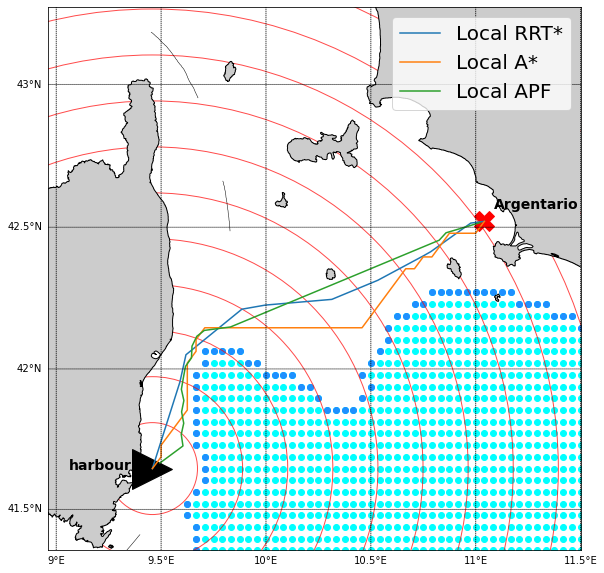

In [195]:
r = 10
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g1x, g1y, "Xr", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x+5000, g1y+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[r], yrs1[r], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[r], asumy1_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs1[r], yapfs1[r], '-', label='Sum APF')
mp2.plot(xrg1[r], yrg1[r], '-', label='Global RRT*')
mp2.plot(xag1[r], yag1[r], '-', label='Global A*')
mp2.plot(xapfg1[r], yapfg1[r], '-', label='Global APF')
mp2.plot(xapflist1[r], yapflist1[r], 'xk', markersize=5)
mp2.plot(xrlist1[r], yrlist1[r], 'xk', markersize=5)
mp2.plot(xalist1[r], yalist1[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xalist1[r][-1], yalist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xapflist1[r][-1], yapflist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl1[r], yrl1[r], '-', label='Local RRT*')
# mp2.plot(xal1[r], yal1[r], '-', label='Local A*')
# mp2.plot(xapfl1[r], yapfl1[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
var=1
# plt.scatter(oxmeteo_[var], oymeteo_[var], color="aqua")
# plt.scatter(x_obsm_[var], y_obsm_[var], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day11l.png', dpi=300, bbox_inches='tight')
plt.show()

## Survey2


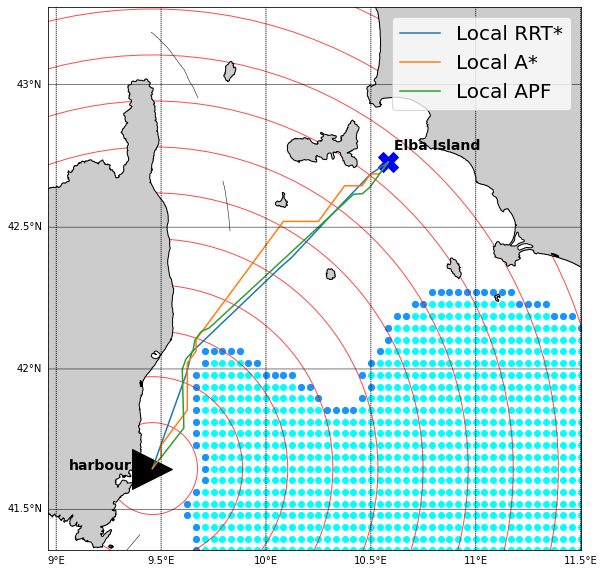

In [197]:
r = 10
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g2x, g2y, "Xb", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g2x+3000, g2y+5000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs2[r], yrs2[r], '-', label='Sum RRT*')
# mp2.plot(asumx2_mp2[r], asumy2_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs2[r], yapfs2[r], '-', label='Sum APF')
mp2.plot(xrg2[r], yrg2[r], '-', label='Global RRT*')
mp2.plot(xag2[r], yag2[r], '-', label='Global A*')
mp2.plot(xapfg2[r], yapfg2[r], '-', label='Global APF')
mp2.plot(xapflist2[r], yapflist2[r], 'xk', markersize=5)
mp2.plot(xrlist2[r], yrlist2[r], 'xk', markersize=5)
mp2.plot(xalist2[r], yalist2[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xapflist2[r][-1], yapflist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xrlist2[r][-1], yrlist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xalist2[r][-1], yalist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl2[r], yrl2[r], '-', label='Local RRT*')
# mp2.plot(xal2[r], yal2[r], '-', label='Local A*')
# mp2.plot(xapfl2[r], yapfl2[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# var=1
# plt.scatter(oxmeteo_[var], oymeteo_[var], color="aqua")
# plt.scatter(x_obsm_[var], y_obsm_[var], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":18}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day11_2l.png', dpi=300, bbox_inches='tight')
plt.show()

# Day12

## Survey1

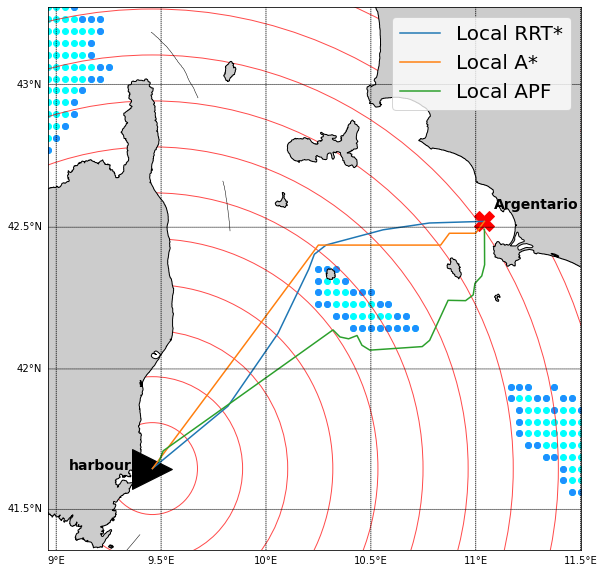

In [202]:
r = 11
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g1x, g1y, "Xr", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g1x+5000, g1y+5000, 'Argentario',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs1[r], yrs1[r], '-', label='Sum RRT*')
# mp2.plot(asumx1_mp2[r], asumy1_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs1[r], yapfs1[r], '-', label='Sum APF')
mp2.plot(xrg1[r], yrg1[r], '-', label='Global RRT*')
mp2.plot(xag1[r], yag1[r], '-', label='Global A*')
mp2.plot(xapfg1[r], yapfg1[r], '-', label='Global APF')
mp2.plot(xapflist1[r], yapflist1[r], 'xk', markersize=5)
mp2.plot(xrlist1[r], yrlist1[r], 'xk', markersize=5)
mp2.plot(xalist1[r], yalist1[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xalist1[r][-1], yalist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xapflist1[r][-1], yapflist1[r][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl1[r], yrl1[r], '-', label='Local RRT*')
# mp2.plot(xal1[r], yal1[r], '-', label='Local A*')
# mp2.plot(xapfl1[r], yapfl1[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
var=5
# plt.scatter(oxmeteo_[var], oymeteo_[var], color="aqua")
# plt.scatter(x_obsm_[var], y_obsm_[var], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":20}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day12l.png', dpi=300, bbox_inches='tight')
plt.show()

## Survey2

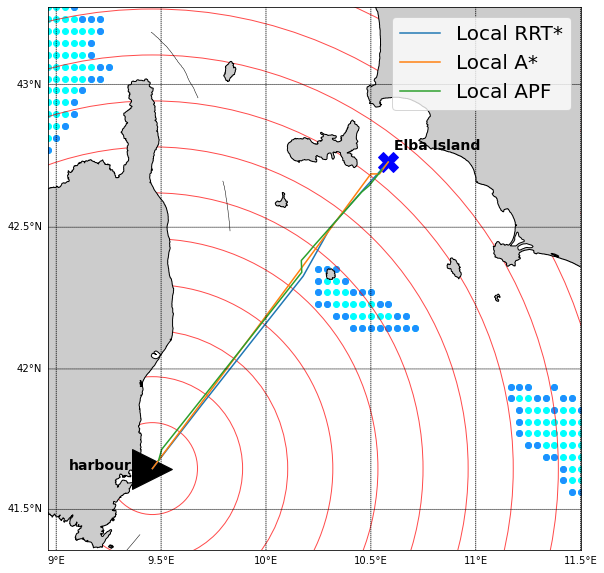

In [204]:
r = 11
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mp2.plot(s1x, s1y, ">k", markersize=40)
mp2.plot(g2x, g2y, "Xb", markersize=20)
plt.text(s1x-11000, s1y-2000, 'harbour',fontsize=14,fontweight='bold',
                    ha='right',va='bottom',color='k')
plt.text(g2x+3000, g2y+5000, 'Elba Island',fontsize=14, fontweight='bold',
                    ha='left',va='bottom',color='k')
# mp2.plot(xrs2[r], yrs2[r], '-', label='Sum RRT*')
# mp2.plot(asumx2_mp2[r], asumy2_mp2[r], '-', label='Sum A*')
# mp2.plot(xapfs2[r], yapfs2[r], '-', label='Sum APF')
mp2.plot(xrg2[r], yrg2[r], '-', label='Global RRT*')
mp2.plot(xag2[r], yag2[r], '-', label='Global A*')
mp2.plot(xapfg2[r], yapfg2[r], '-', label='Global APF')
mp2.plot(xapflist2[r], yapflist2[r], 'xk', markersize=5)
mp2.plot(xrlist2[r], yrlist2[r], 'xk', markersize=5)
mp2.plot(xalist2[r], yalist2[r], 'xk', markersize=5, label='Re-planning way-points')
mp2.plot(xapflist2[r][-1], yapflist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xrlist2[r][-1], yrlist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
mp2.plot(xalist2[r][-1], yalist2[r][-1], 'Pr', markersize=15,markeredgecolor='k')
for i in range(le-li-5):
    plt.pcolor(x, y, cost[i], cmap=ListedColormap(['white', 'dodgerblue']),alpha=0.5-i*0.05)
for i in range(le-li-5):
    plt.contour(x, y, cost[i], colors =colorbar[i],linewidths=1, levels=0, alpha=0.1+i*0.1)    # le più recenti 

# mp2.plot(xrl2[r], yrl2[r], '-', label='Local RRT*')
# mp2.plot(xal2[r], yal2[r], '-', label='Local A*')
# mp2.plot(xapfl2[r], yapfl2[r], '-', label='Local APF')
# plt.scatter(map_x_, map_y_, color="aqua")
# plt.scatter(map_x_2, map_y_2, color="dodgerblue")
# var=5
# plt.scatter(oxmeteo_[var], oymeteo_[var], color="aqua")
# plt.scatter(x_obsm_[var], y_obsm_[var], color="dodgerblue")
# for i in range(le-li):
#     ax.add_patch(plt.Circle(xy=(s1x, s1y), radius=18000*(i+1),
#                                 color='r', alpha=0.7, fill = False))
# for i in range(le-li):
#     ax.add_patch(pltpat.Ellipse(xy=(s1x, s1y),width= 2*ww *(i+1), height=2*hh*(i+1),
#                                 color='red', alpha=0.7, fill = False)) 
mp2.drawmeridians(np.arange(9,12,0.5),labels=[0,0,0,1]) #longitudes
mp2.drawparallels(np.arange(41,44,0.5),labels=[1,0,0,0]) #latitudes
ax.legend(prop={"size":18}, loc="upper right")
# for i in range(len(obstacle_list[k-1])):
#     ax.add_patch(plt.Circle(xy=(obstacle_list2[k-1][i][0], obstacle_list2[k-1][i][1]), radius=4500,
#                             color='b', alpha=0.3))
# plt.plot(x_obsl2_, y_obsl2_, '.', color="sienna", markersize=20)
# plt.plot(x_obsm2_[k], y_obsm2_[k], '.', color="dodgerblue", markersize=20)
mp2.fillcontinents()
mp2.drawcoastlines()
mp2.drawstates()
mp2.drawcountries()
plt.savefig('day12_2l.png', dpi=300, bbox_inches='tight')
plt.show()